In [1]:
import os
os.chdir('../')

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import torch
import torch.nn as nn

import torch.nn.functional as F
from torch import optim
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

import numpy as np

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from collections import OrderedDict

from lateral_connections import LateralModel, VggModel
from lateral_connections import VggWithLCL
from lateral_connections import MNISTCDataset
from lateral_connections.loaders import get_loaders, load_mnistc
from lateral_connections.layers import LaterallyConnectedLayer, LaterallyConnectedLayer2, LaterallyConnectedLayer3
from lateral_connections.torch_utils import *
from lateral_connections.dataset import TinyDataset, TinyDatasetEasy

import wandb
import datetime

config = {
    'num_classes': 10,
    'learning_rate': 3e-4,
    'num_multiplex': 2,
    'batch_size': 4,
    'num_epochs': 20,
    'lcl_alpha': 0.2,
    'lcl_eta': 0.0, # Empirically evaluated :eta to switch ~30 from-to connections (0.0360: 40, 0.0160: 30, 0.0030: 10, 0.0015: 5)
    'lcl_theta': 0.2,
    'lcl_iota': 0.2,
    'lcl_distance': 3,
    'conv_size': 10,
    'use_scaling': False,
}

lcl = LaterallyConnectedLayer3(config['num_multiplex'], config['conv_size'], 14, 14,
                              d=config['lcl_distance'],
                              prd=config['lcl_distance'],
                              disabled=False,
                              alpha=config['lcl_alpha'],
                              beta=(1 / ((50000/2) / config['batch_size'])),
                              eta=config['lcl_eta'],
                              theta=config['lcl_theta'],
                              iota=config['lcl_iota'],
                              use_scaling=config['use_scaling'],
                              random_k_change=False,
                              random_multiplex_selection=False,
                              gradient_learn_k=False)
lcl.to(lcl.device)
lcl.device

lcl.K -= 0.95 * lcl.K


buffer = {
    'horizontal': { 'single': [], 'both': [] },
    'vertical': { 'single': [], 'both': [] }
}

In [4]:
def plot_kernels(K, plot_scale=3):
    num_kernels = K.shape[0]

    fig, axs = plt.subplots(num_kernels, num_kernels, figsize=(plot_scale*num_kernels, plot_scale*num_kernels))

    kernel_data = K.cpu()

    for x in range(num_kernels):
        for y in range(num_kernels):
            axs[x,y].imshow(kernel_data[x,y,...])
            
    plt.show()
    plt.close()
    
def plot_images(x, plot_scale=3, vmax=None):
    fig, axs = plt.subplots(1, x.shape[1], figsize=(plot_scale*x.shape[1], plot_scale))
    
    for i in range(x.shape[1]):
        if vmax is None:
            axs[i].imshow(x[0,i,...])
        else:
            axs[i].imshow(x[0,i,...], vmax=vmax)
        axs[i].set_title(f"Pattern #{i}")
    plt.show()
    
def plot_impact(x):
    plt.imshow(x[0].cpu())
    plt.ylabel('Source FM')
    plt.xlabel('Target FM')
    plt.show()
    
def plot_history(buffer, title=''):
    x = torch.stack(buffer).transpose(0,1)

    fig, ax = plt.subplots(figsize=(15,5))
    ax.imshow(x, vmin=0, vmax=1)
    ax.set_ylabel('Multiplex Cell', fontsize=16)
    ax.set_xlabel('# Iteration', fontsize=16)
    ax.set_title(title, fontsize=20)
    plt.tight_layout()
    plt.show()

### Horizontal Images ":images"

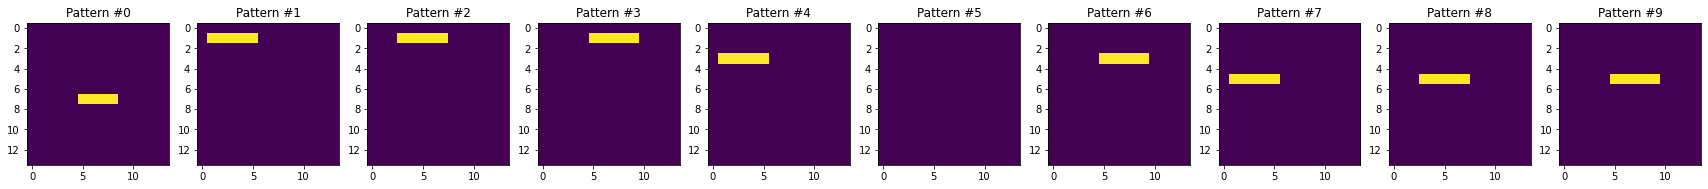

torch.Size([1, 10, 14, 14])

In [5]:
images = 0 * torch.ones((1, 10, 14, 14))
#images[0, 0, 7, 7] = 1
images[0, 0, 7, 5:9] = 1

for x in range(3):
    for y in range(3):
        i = 3*x+y+1
        xdiff = 2*x-2
        ydiff = 2*y-2
        #images[:, i, 7+xdiff, 7+ydiff] = 1
        images[:, i, 3+xdiff, 3+ydiff:8+ydiff] = 1
        
#images[0, 5] = 0.2 * torch.normal(torch.zeros(images[0, 5].shape), torch.ones(images[0, 5].shape))
images[0, 5] = 0

plot_images(images, vmax=1)
images.shape

### Vertical Images ":images2"

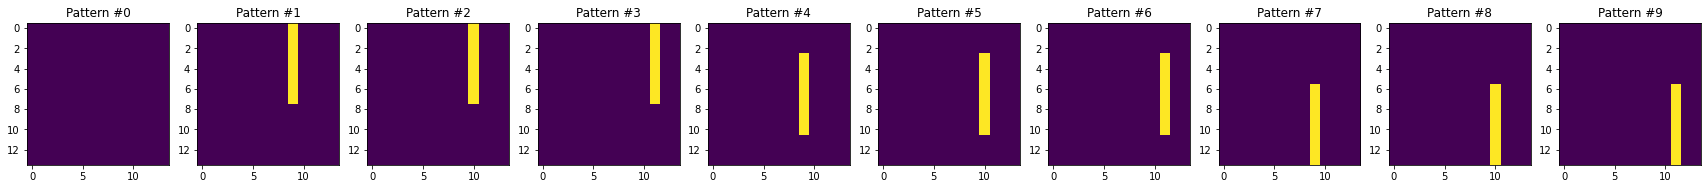

torch.Size([1, 10, 14, 14])

In [6]:
images2 = 0 * torch.ones((1, 10, 14, 14))

for x in range(3):
    for y in range(3):
        i = 3*x+y+1
        xdiff = 3*x-3
        ydiff = 1*y-1
        images2[:, i, 3+xdiff:11+xdiff, 10+ydiff] = 1
        
#images2[0, 0] = 0.2 * torch.normal(torch.zeros(images2[0, 0].shape), torch.ones(images2[0, 0].shape))
images2[0, 0] = 0

plot_images(images2, vmax=1)
images2.shape

### forward pass of LCL

In [7]:
def do_kernel_update(A, selected_multiplex_mask):
    # Lateral Connection Reinforcement
    K_change = torch.zeros(size=lcl.K.shape, device=lcl.device)

    # Iterate through the different necessary shifts between the feature maps
    # to account for all positions in the kernel K
    #
    for x in range(lcl.K.shape[-2]):
        for y in range(lcl.K.shape[-1]):
            # source and target feature maps are transposed to enable broadcasting across
            # the batch size dimension
            #
            xoff_f = - lcl.d + x
            yoff_f = - lcl.d + y
            source_fms = A[:, :, max(0,xoff_f):A.shape[-2]+min(xoff_f,0), max(0,yoff_f):A.shape[-1]+min(0,yoff_f)]
            source_fms = source_fms.transpose(0,1)

            xoff_i = lcl.d - x
            yoff_i = lcl.d - y
            target_fms = A[:, :, max(0,xoff_i):A.shape[-2]+min(xoff_i,0), max(0,yoff_i):A.shape[-1]+min(0,yoff_i)]
            target_fms = target_fms.transpose(0,1).unsqueeze(1)

            # calculate the product of all feature maps (source) together with the
            # to-be-influenced feature map (target) efficiently
            #
            # Initially, self.A contains [batch_size, num_fm, fm_height, fm_width] dimensions
            #
            # Designations of einsum characters:
            #   a:  Extra dim to ensure each FM in target is multipled with the whole source blob
            #   b:  Feature Map #
            #   c:  Batch (see the transpose(0,1) calls)
            #   d:  Feature Map Height
            #   e:  Feature Map Width
            #
            tmp = torch.einsum('abcde,bcde->cab', target_fms, source_fms)
            
            # inhibit inactive multiplex cell changes
            #
            tmp *= selected_multiplex_mask[:,:,:,0,0]

            # inhibit multiplex repetitions
            #
            diagonal_repetition_mask = 1 - torch.eye(lcl.num_fm.item(), device=lcl.device).repeat(lcl.n, lcl.n)
            diagonal_repetition_mask += torch.eye(int(lcl.num_fm*lcl.n), device=lcl.device)
            tmp *= diagonal_repetition_mask.unsqueeze(0)

            # Average across the batch size
            #
            number_of_samples_per_pixel = torch.count_nonzero(tmp, dim=0)
            number_of_samples_per_pixel[torch.where(number_of_samples_per_pixel == 0)] = 1
            K_change[:, :, x, y] = torch.sum(tmp, dim=0) / number_of_samples_per_pixel

    K_change /= lcl.K.shape[-2] * lcl.K.shape[-1]
            
    abs_sum = torch.sum(torch.abs(K_change), dim=(-2,-1))
    changing_kernels = abs_sum.to(torch.bool).to(torch.long).unsqueeze(-1).unsqueeze(-1)
    unchanged_kernels = 1 - changing_kernels
    
    lcl.K *= (1 - lcl.alpha) * changing_kernels + unchanged_kernels
    lcl.K += lcl.alpha * K_change
    torch.clip_(lcl.K, min=0, max=1)
    
    """
    fig,axs = plt.subplots(K_change.shape[0], K_change.shape[1], figsize=(3*K_change.shape[1], 3*K_change.shape[0]))
    for x in range(K_change.shape[0]):
        for y in range(K_change.shape[1]):
            if impact_small[0,x,y] > 0:
                axs[y,x].imshow(K_change[x,y,...].cpu())
            else:
                axs[y,x].axis('off')
    plt.show()
    """
    
def do_round(images, debug=False):
    A_raw = images.reshape((1,10,14,14))
    A_raw = A_raw.to(lcl.device)

    batch_size = A_raw.shape[0]

    A = A_raw.repeat(1, config['num_multiplex'], 1, 1)
    padded_A = lcl.pad_activations(A)

    impact = []
    for idx in range(padded_A.shape[1]):
        kernel = lcl.K[:, idx, ...].unsqueeze(1)
        lateral_impact = F.conv2d(padded_A, kernel, groups=int(lcl.n*lcl.num_fm), padding=0)

        impact.append(torch.sum(lateral_impact.unsqueeze(2), dim=(-2,-1)))

    impact = torch.cat(impact, dim=2)

    impact -= impact.min()
    if impact.max != 0:
        impact /= impact.max()

    impact_p1 = torch.clone(impact)
    
    # -----

    #eta = 0.036
    impact += lcl.eta * torch.normal(torch.zeros(impact.shape), torch.ones(impact.shape)).to(lcl.device)
    impact_p2 = torch.clone(impact)

    # -----

    diagonal_repetition_mask = 1 - torch.eye(lcl.num_fm.item(), device=lcl.device).repeat(lcl.n, lcl.n)
    diagonal_repetition_mask += torch.eye(int(lcl.num_fm*lcl.n), device=lcl.device)
    impact *= diagonal_repetition_mask.unsqueeze(0)
    impact_p3 = torch.clone(impact)

    # -----

    # Select the highest active multiplex (SOURCE) cells and disable others,
    # ensuring that only the most active multiplex source cell is active in
    # any multiplex source unit
    #
    # Implementation uses the answer provided here:
    # https://discuss.pytorch.org/t/set-max-value-to-1-others-to-0/44350/8
    # (calculate argmax along the different multiplex cell repetitions)
    #
    impact_reshaped = impact.reshape((batch_size, lcl.n, lcl.num_fm, lcl.n * lcl.num_fm))

    idx = torch.argmax(impact_reshaped, dim=1, keepdims=True)
    active_multiplex_source_mask = torch.zeros_like(impact_reshaped).scatter_(1, idx, 1.)
    active_multiplex_source_mask = active_multiplex_source_mask.reshape((batch_size, lcl.n*lcl.num_fm, lcl.n*lcl.num_fm))

    impact *= active_multiplex_source_mask

    impact_p4 = torch.clone(impact)

    # lehl@2022-06-22:
    # Selecting the most active target source maps, similar
    # to the selection of active source feature maps above
    #
    impact_reshaped = impact.transpose(0,1).reshape((lcl.n*lcl.num_fm, batch_size, lcl.n, lcl.num_fm))
    impact_target_sum = torch.sum(impact_reshaped, dim=0)
    idx = torch.argmax(impact_target_sum, dim=1, keepdims=True)
    active_multiplex_target_mask = torch.zeros_like(impact_target_sum).scatter_(1, idx, 1.).reshape((batch_size, lcl.n*lcl.num_fm))
    active_multiplex_target_mask = active_multiplex_target_mask * impact.transpose(1,0)
    active_multiplex_target_mask = active_multiplex_target_mask.transpose(1,0)

    impact *= active_multiplex_target_mask
    
    
    impact_p5 = torch.clone(impact)

    # (!!!) lehl@2022-06-22: TODO: only use a subset? top n=50%?
    # Taking a quantile threshold for each target_fm (= across source_fms)
    #
    # threshold :th is based on the already turned off multiplex cells, i.e. only :num_fm should be available
    # but chosen from :num_fm * :n indices
    #
    # th = float(1 - (0.5 / self.n)) # (1 - top%/n)
    # impact_threshold = torch.quantile(impact.reshape((impact.shape[0], impact.shape[1]*impact.shape[2])), th, dim=1)
    # # impact_threshold = torch.quantile(impact.reshape((impact.shape[0], impact.shape[1]*impact.shape[2])), 0.8, dim=1)
    # indices = torch.where(impact >= impact_threshold.unsqueeze(-1).unsqueeze(-1))


    # # impact_threshold = torch.quantile(impact, 0.5, dim=1)
    # # indices = torch.where(impact >= impact_threshold.unsqueeze(1))
    indices = torch.where(impact > torch.Tensor([0]).unsqueeze(-1).unsqueeze(-1).to(lcl.device))


    large_K = lcl.K.repeat(batch_size, 1, 1, 1, 1)
    selected_multiplex_mask = torch.zeros(large_K.shape, device=lcl.device, dtype=torch.bool)
    selected_multiplex_mask[indices] = 1.0

    impact_small = torch.zeros(impact.shape)
    impact_small[indices] = 1

    # -----
    
    if debug:
        fig, axs = plt.subplots(1, 6, figsize=(3*6, 3))
        fig.suptitle('Multiplex Selection ("Impact")')
        axs[0].imshow(impact_p1[0].cpu())
        axs[0].set_title('Initial Lateral Impact')
        axs[1].imshow(impact_p2[0].cpu())
        axs[1].set_title('Added Noise')
        axs[2].imshow(impact_p3[0].cpu())
        axs[2].set_title('Removed Identity References')
        axs[3].imshow(impact_p4[0].cpu())
        axs[3].set_title('Selected Active Source FMs')
        axs[4].imshow(impact_p5[0].cpu())
        axs[4].set_title('Selected Active Target FMs')
        axs[5].imshow(impact_small[0].cpu())
        axs[5].set_title('Selected Multiplex Connections')
        for plot_idx in range(6):
            axs[plot_idx].set_ylabel('Source FM')
            axs[plot_idx].set_xlabel('Target FM')
        plt.tight_layout()
        plt.show()
        plt.close()
    
    # -----
    
    padded_A = lcl.pad_activations(torch.clone(A_raw.repeat(1, lcl.n, 1, 1)))

    large_K = lcl.K.repeat(batch_size, 1, 1, 1, 1)
    large_K *= selected_multiplex_mask

    L = torch.zeros((batch_size, lcl.n*lcl.num_fm, lcl.fm_height, lcl.fm_width), device=lcl.device)

    for b in range(batch_size):
        L[b, ...] = F.conv2d(padded_A[b, ...].unsqueeze(0), large_K[b,...], padding=0) / lcl.num_fm
        #L[b, ...] = F.conv2d(padded_A[b, ...].unsqueeze(0), minmax_on_fm(large_K[b,...]), padding=0) / lcl.num_fm
        
    output = torch.sum(L.reshape((batch_size, lcl.n, lcl.num_fm, L.shape[-2], L.shape[-1])), dim=1)
    if debug:
        plot_images(output.cpu())
    
    """
    print('Feature Map Input')
    plot_images(images)
    print('LCL Output')
    plot_images(output.reshape((10,1,14,14)).cpu())
    print('Feature Map Input + LCL Output')
    plot_images(0.5*images + 0.5*output.reshape((10,1,14,14)).cpu())
    """
    
    # -----
    
    do_kernel_update(A, selected_multiplex_mask)
    
    return torch.sum(impact_p5[0].cpu().detach(), dim=0).to(torch.bool).to(torch.int)

### Storing a single pattern (horizontal images)

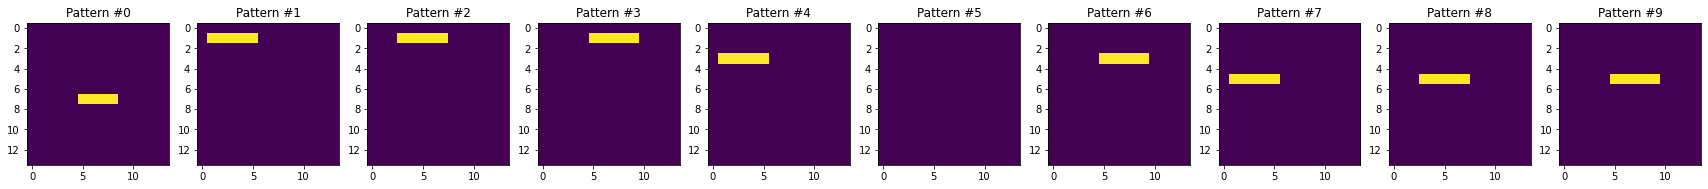

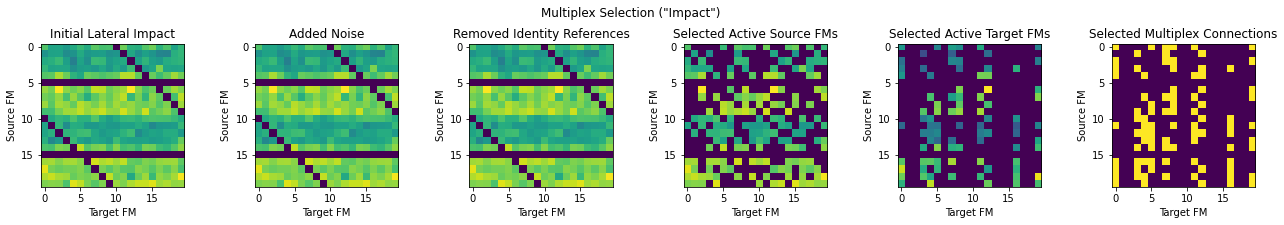

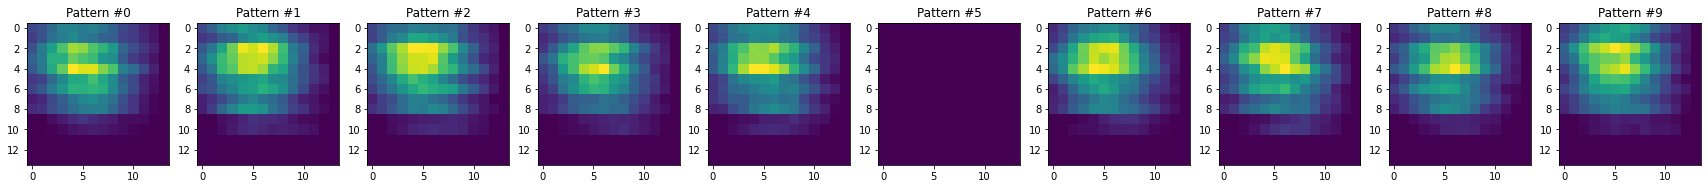

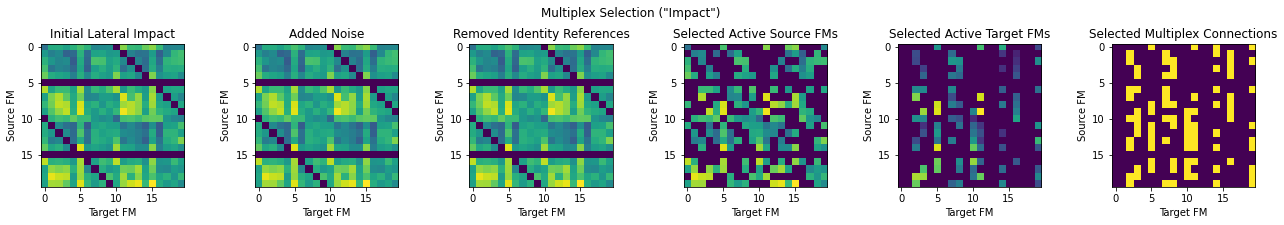

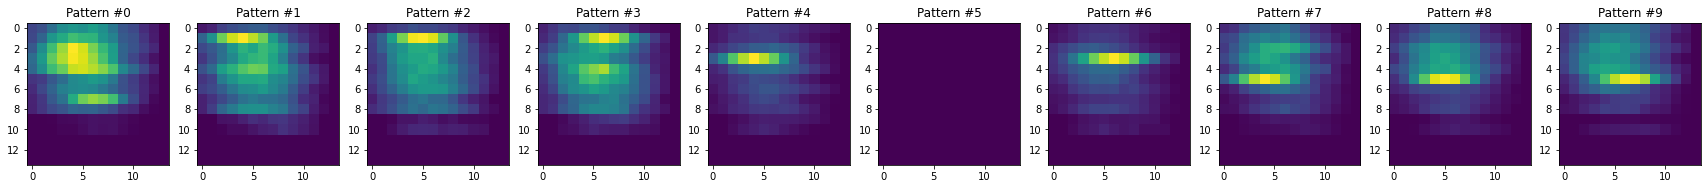

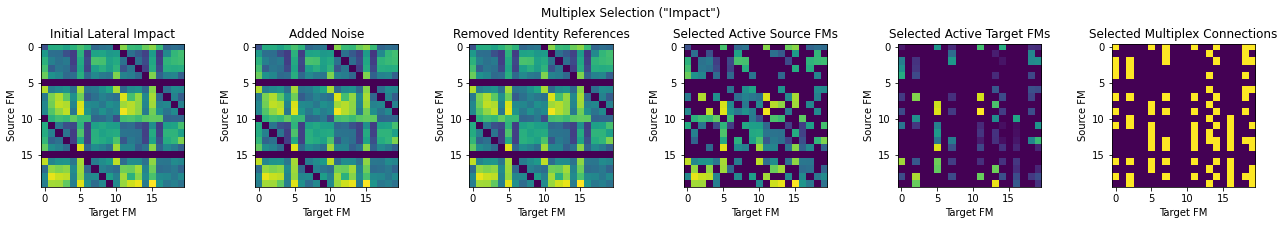

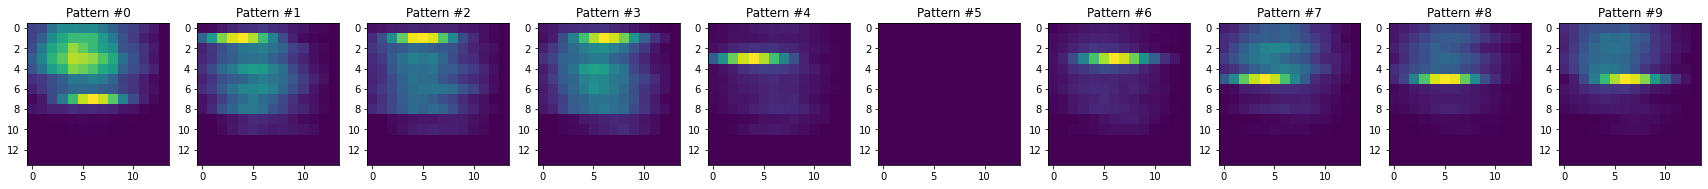

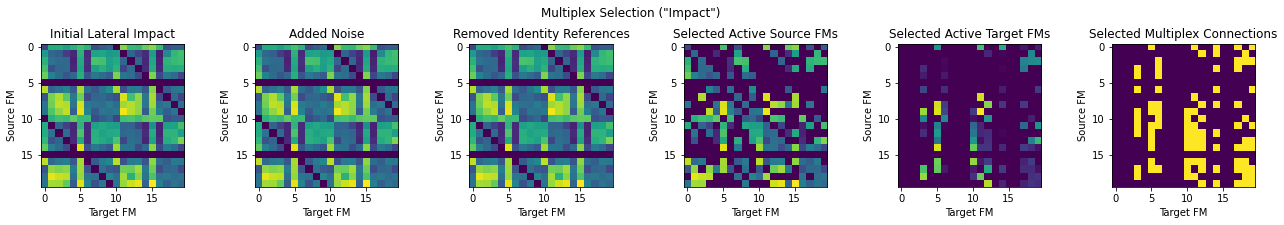

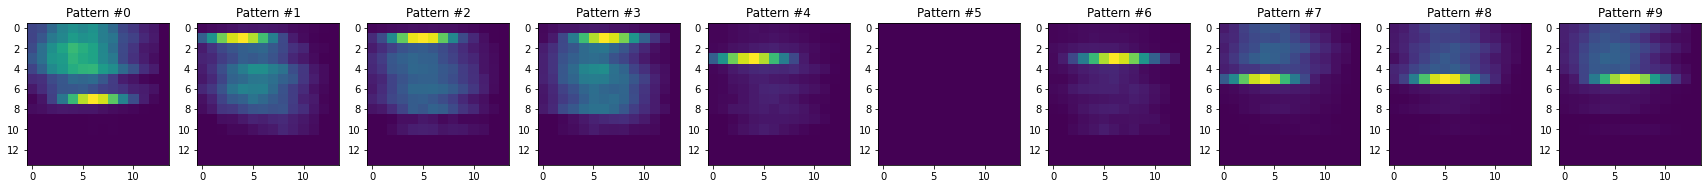

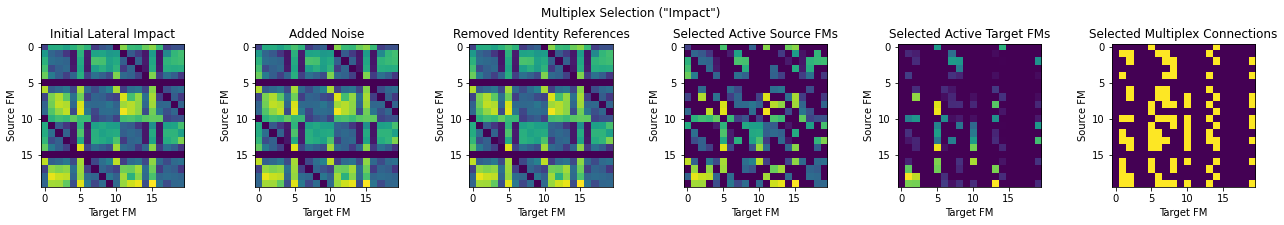

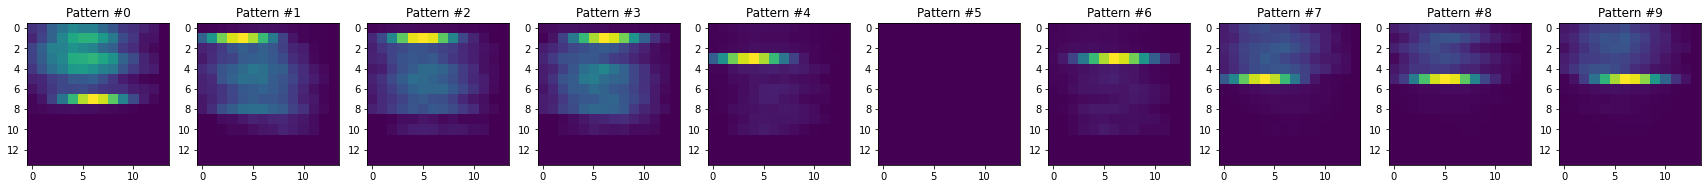

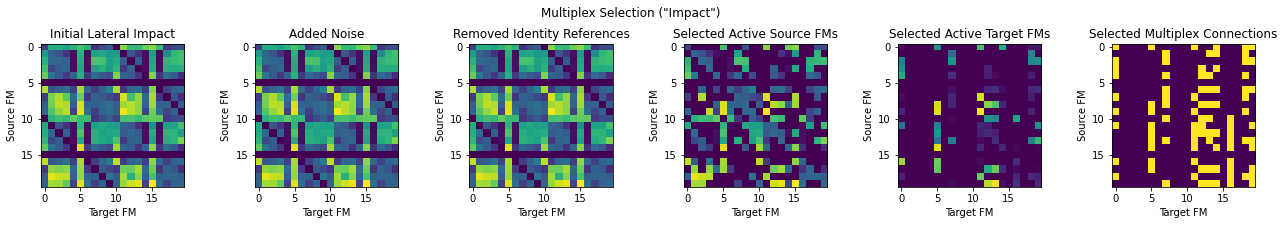

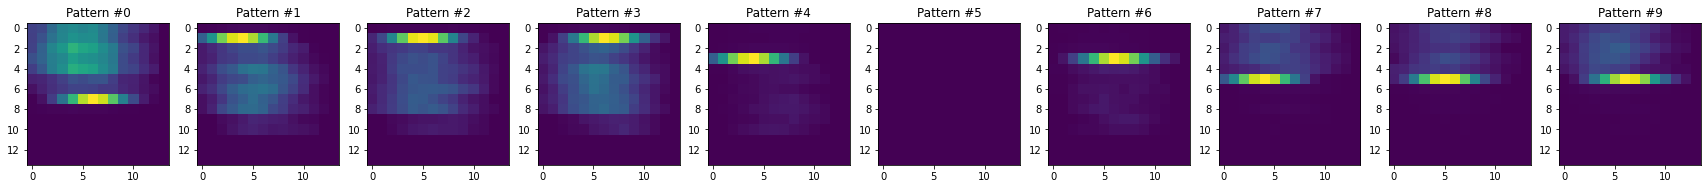

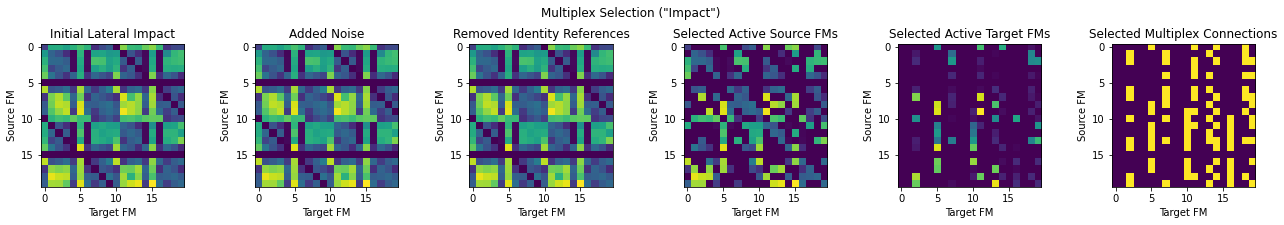

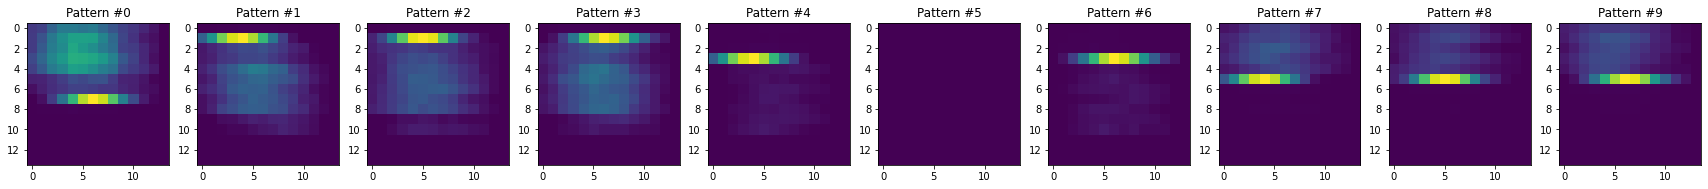

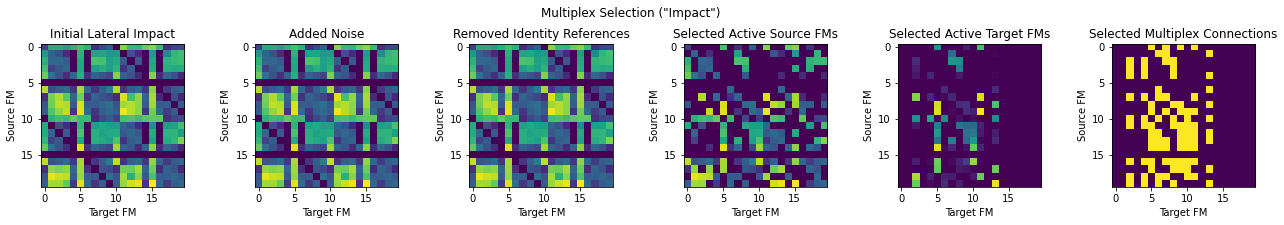

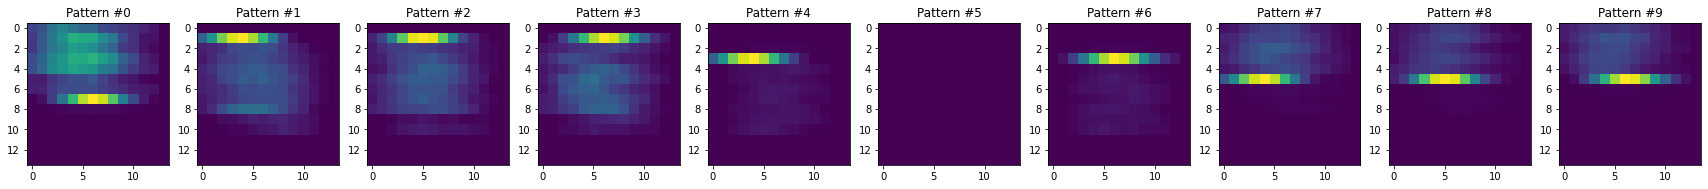

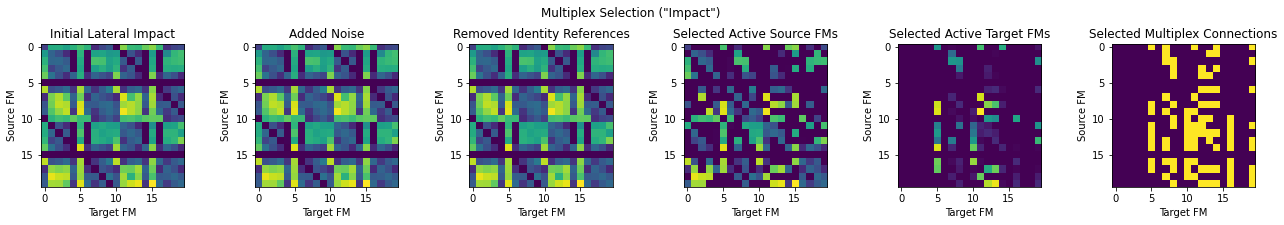

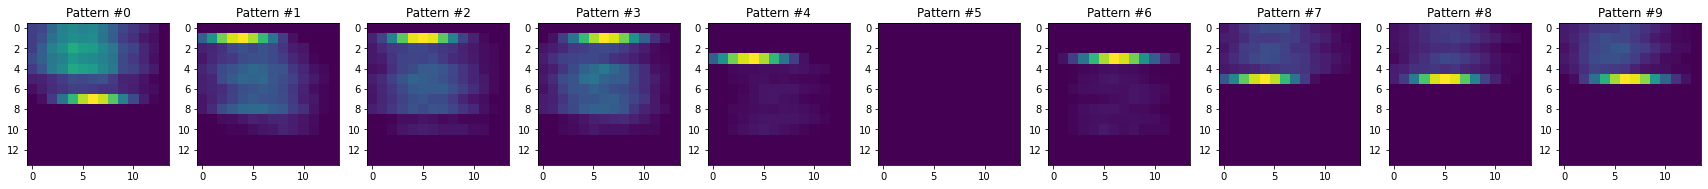

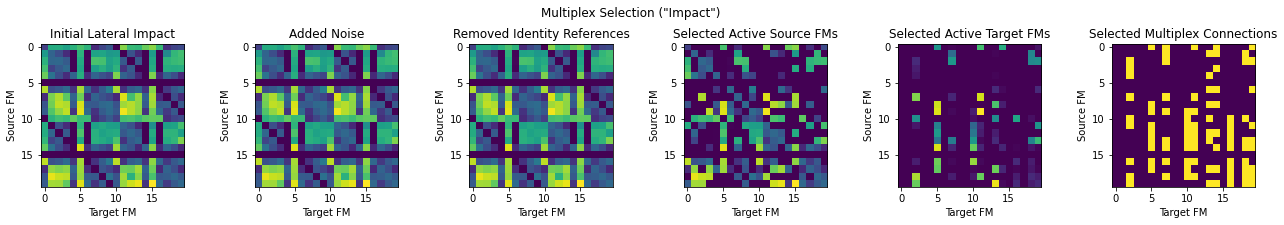

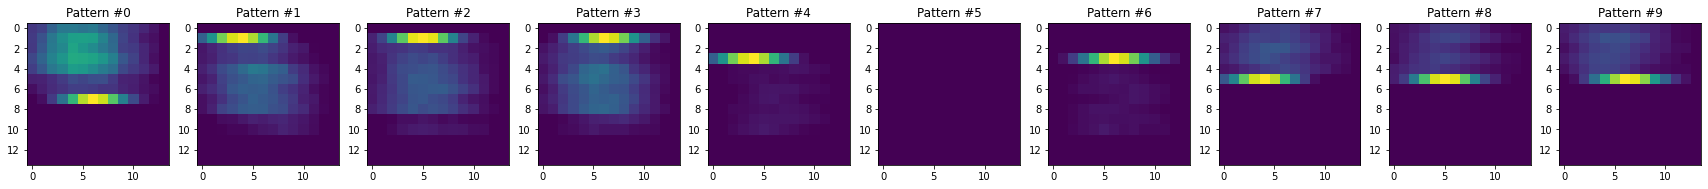

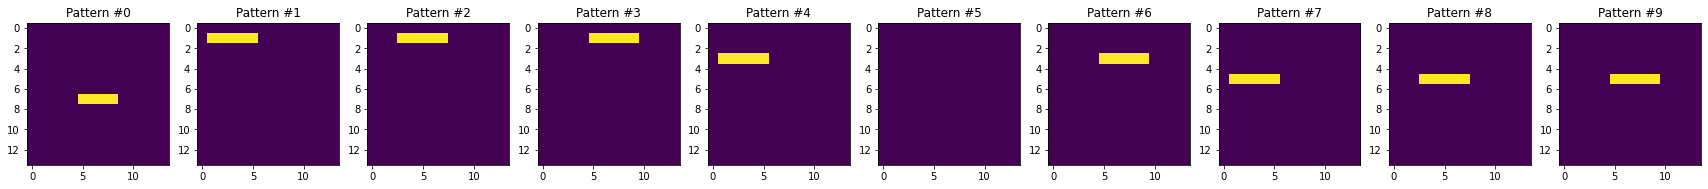

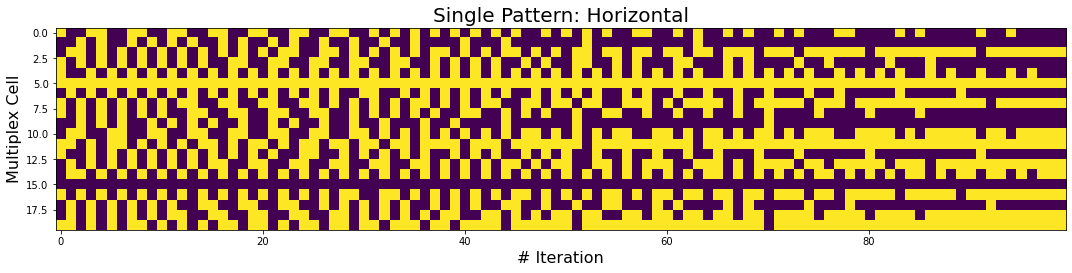

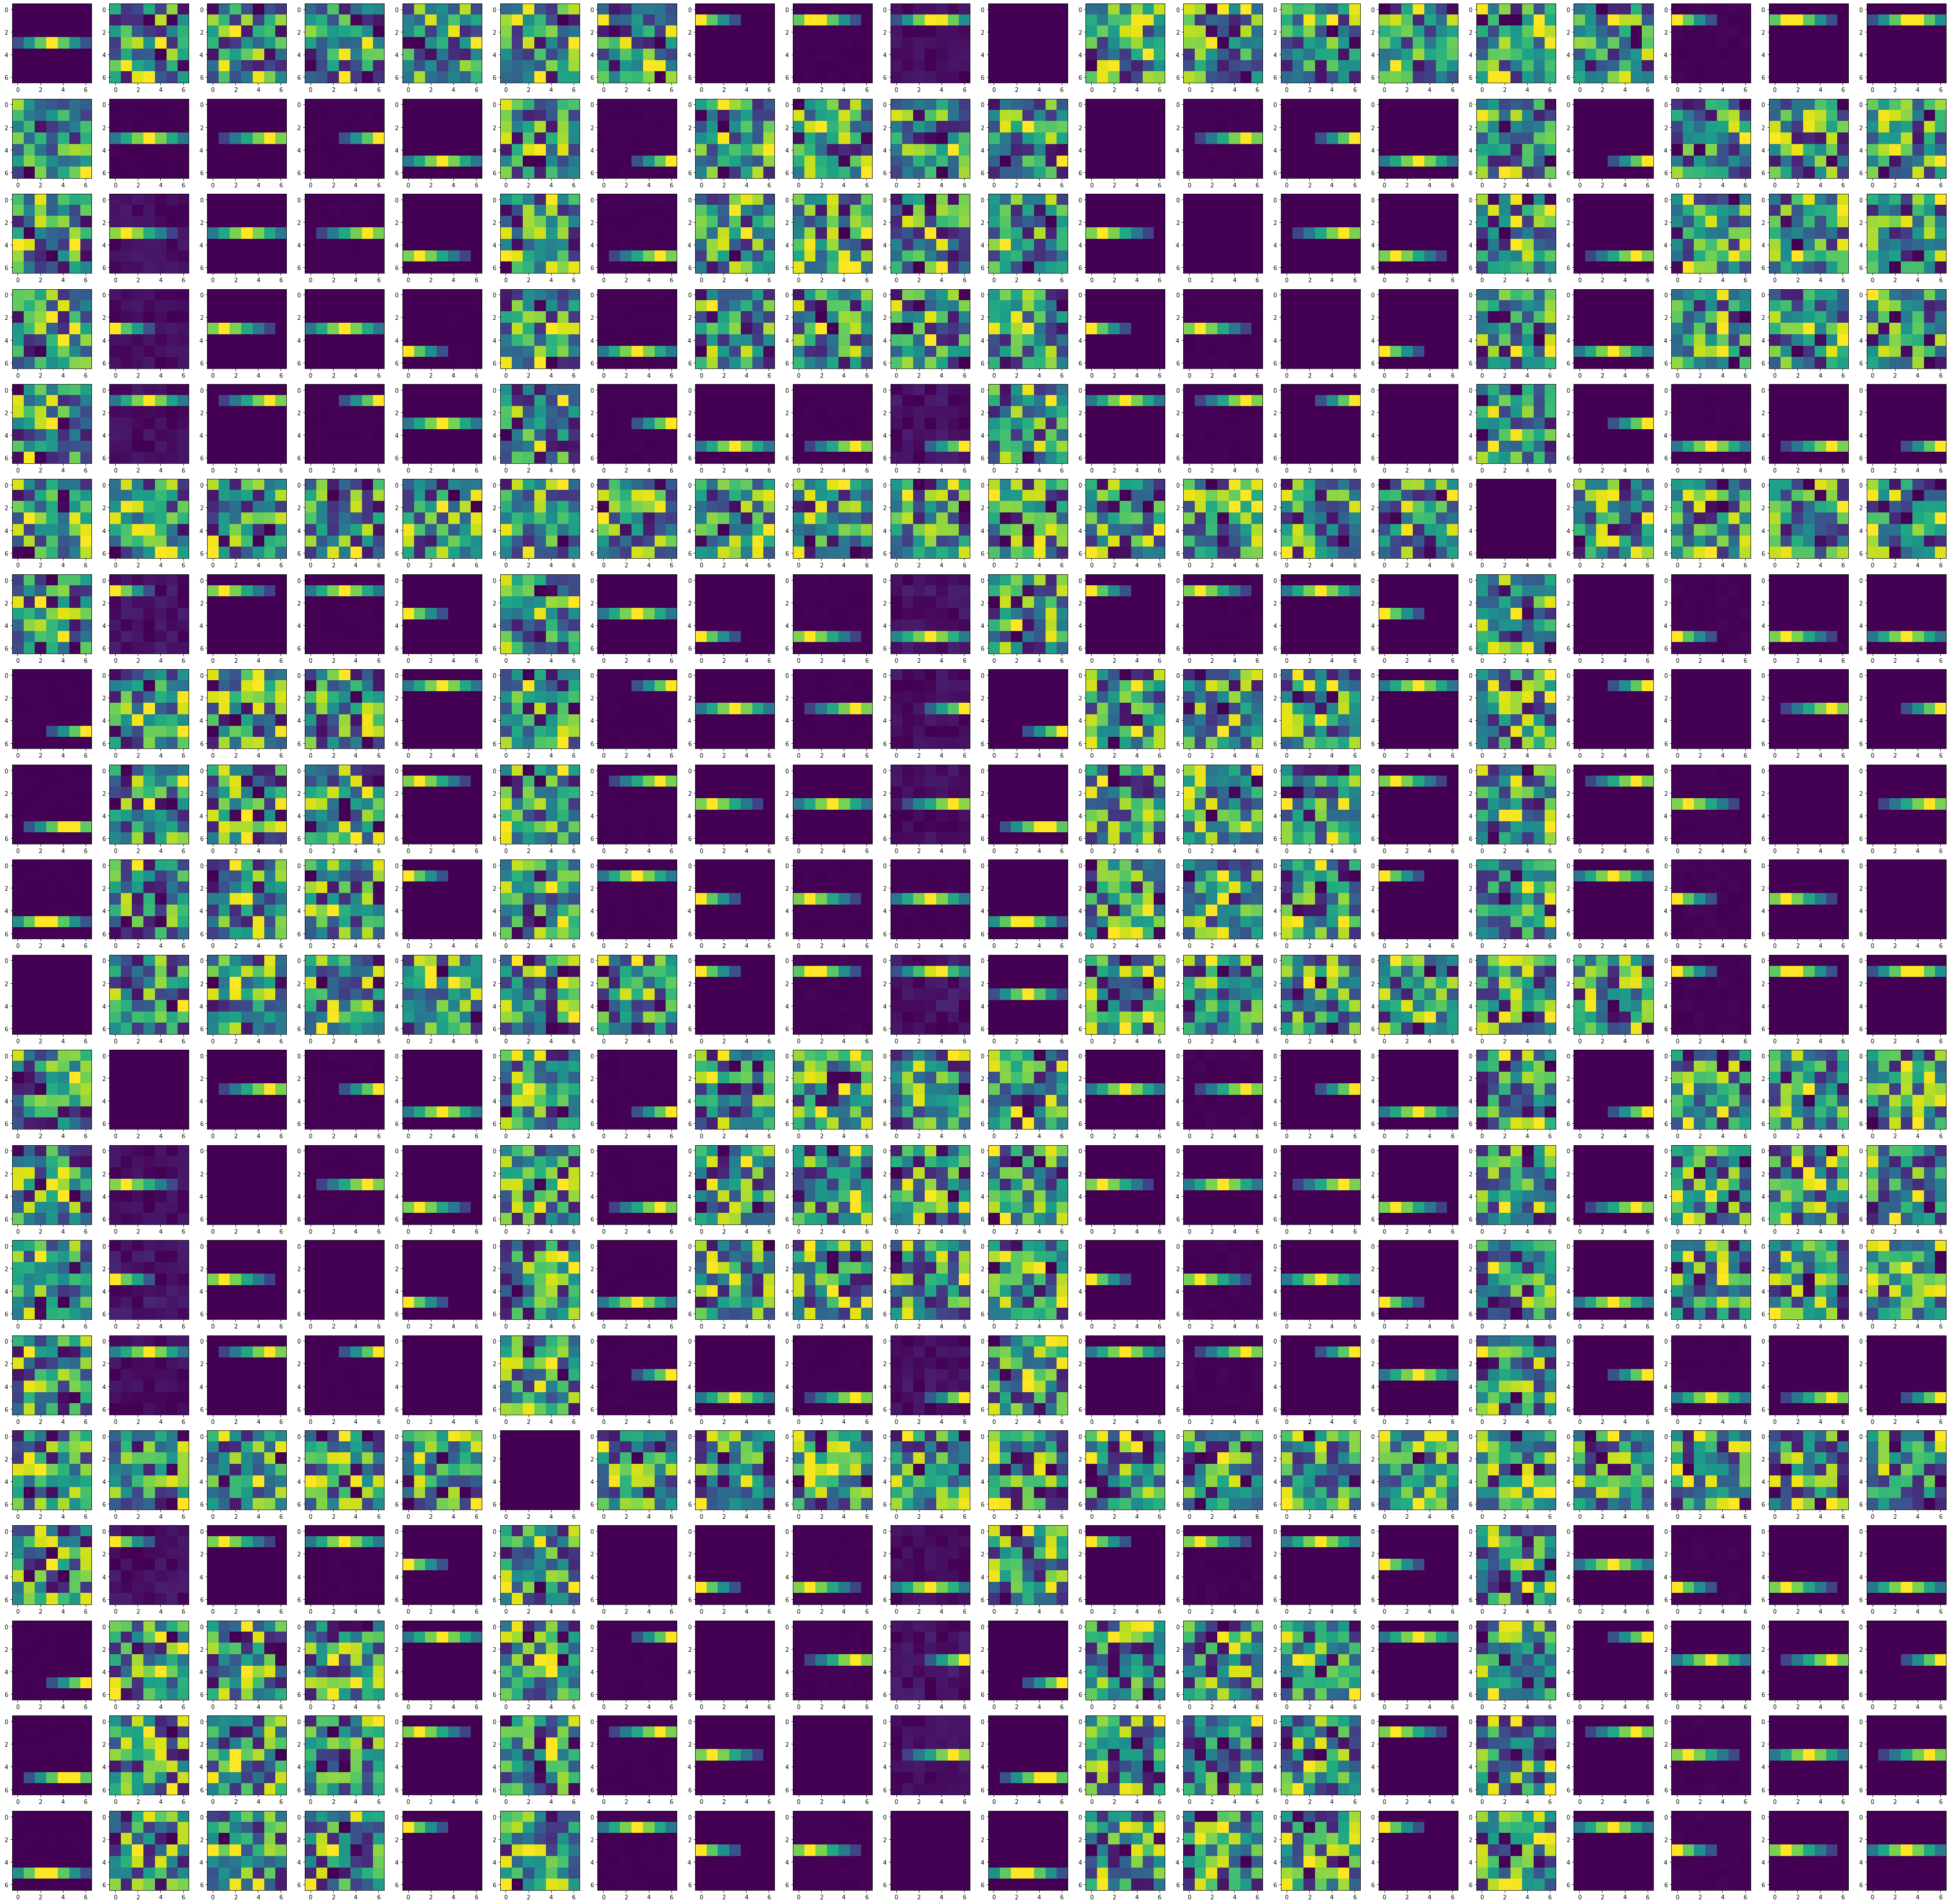

In [8]:
plot_images(images)
for i in range(100):
    buffer['horizontal']['single'].append(do_round(images, i%10==0))
plot_images(images)
plot_history(buffer['horizontal']['single'], 'Single Pattern: Horizontal')
plot_kernels(lcl.K)

### Storing a different pattern (vertical images)

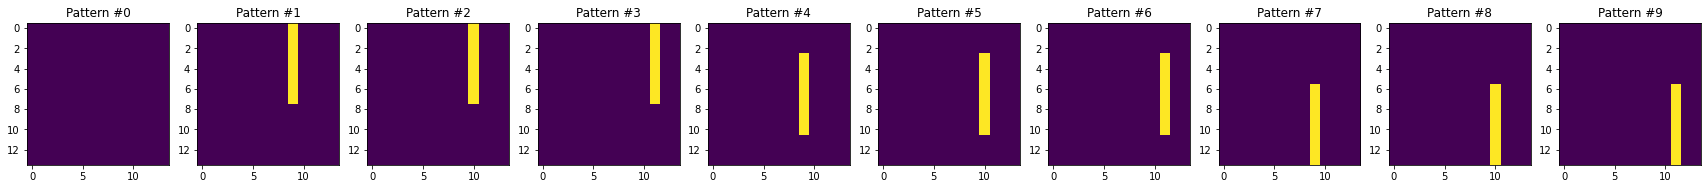

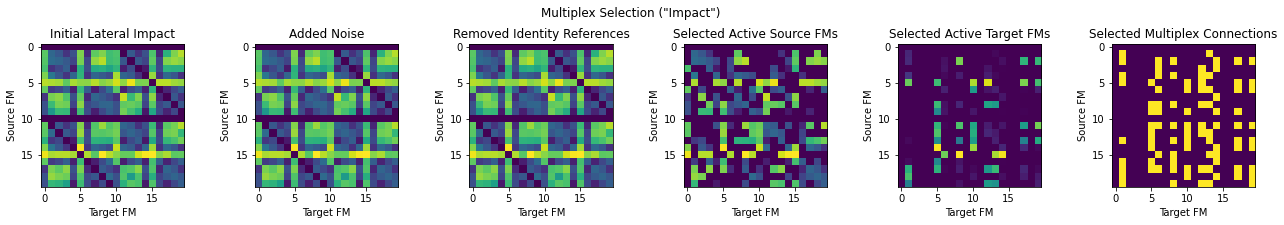

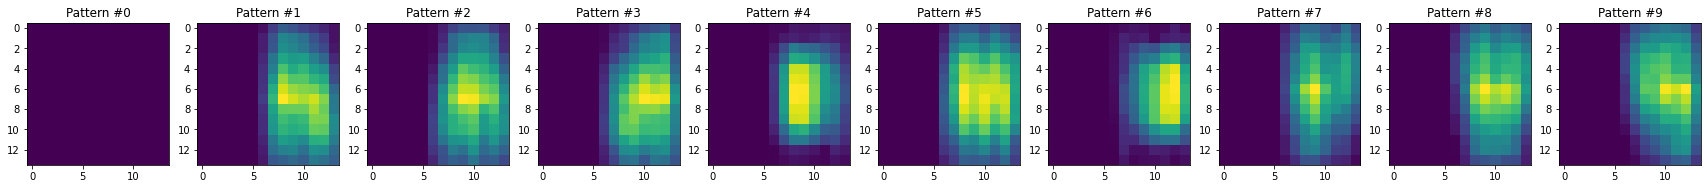

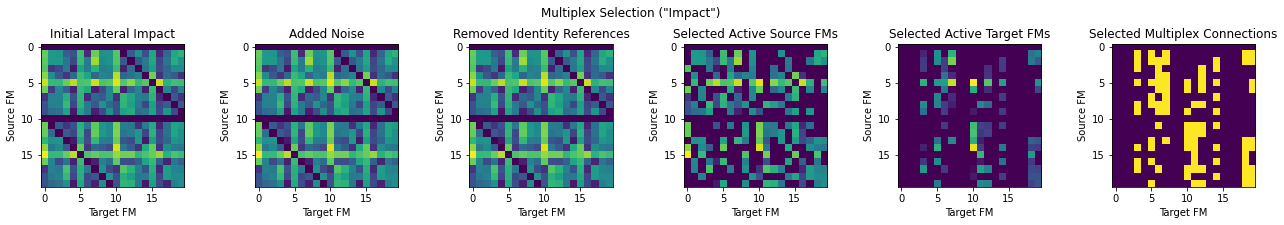

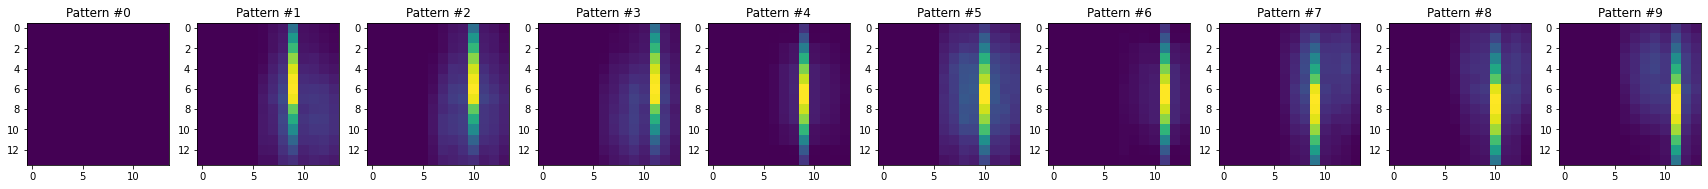

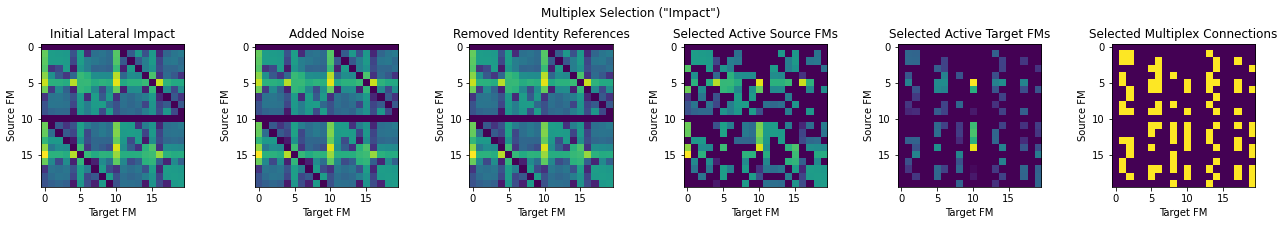

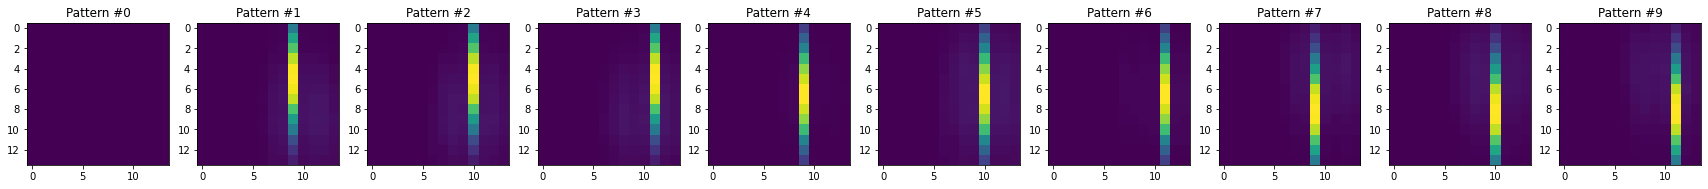

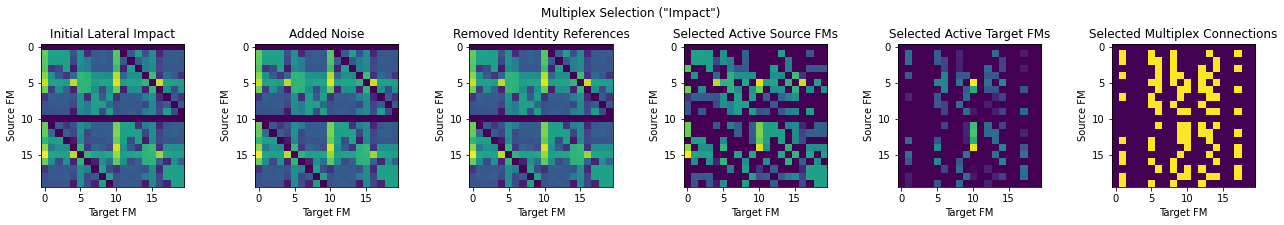

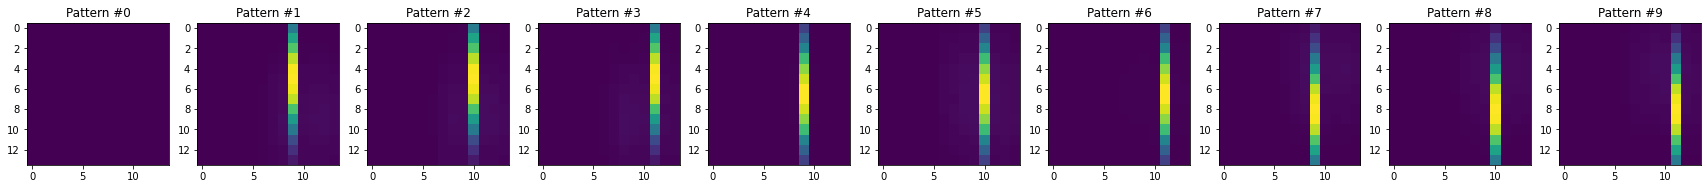

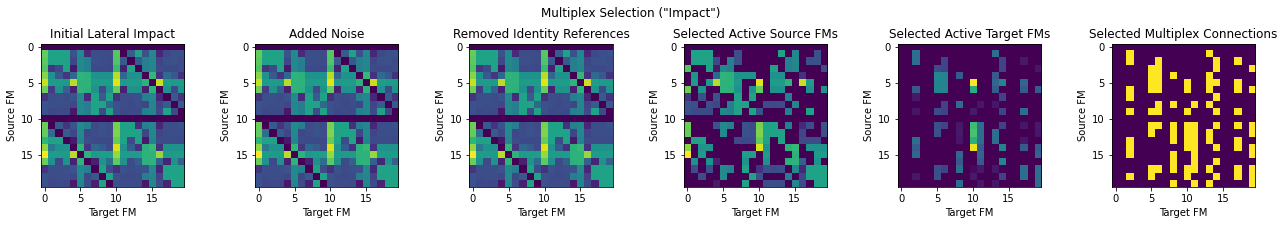

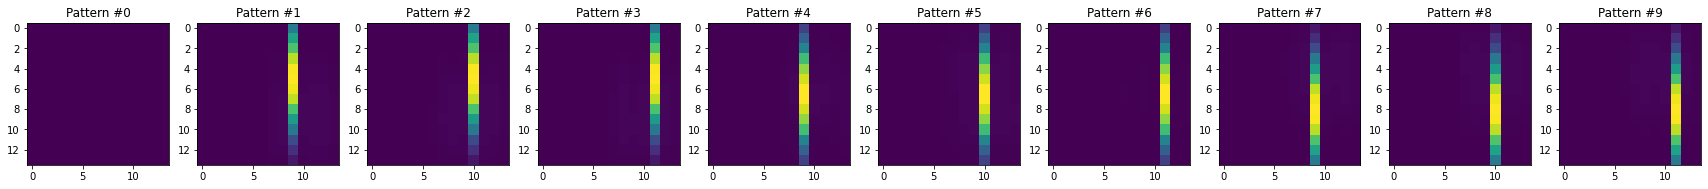

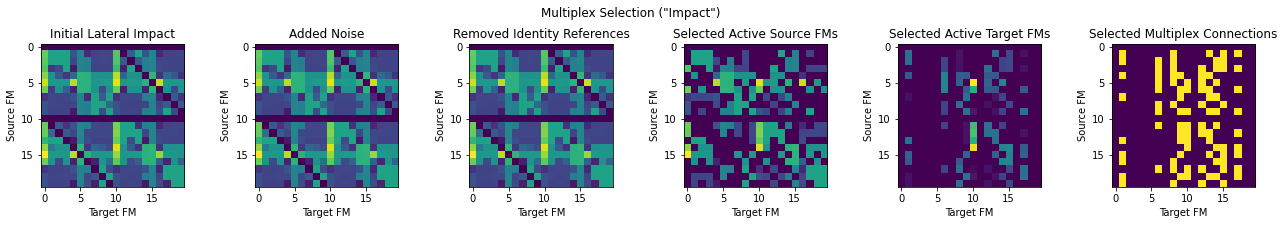

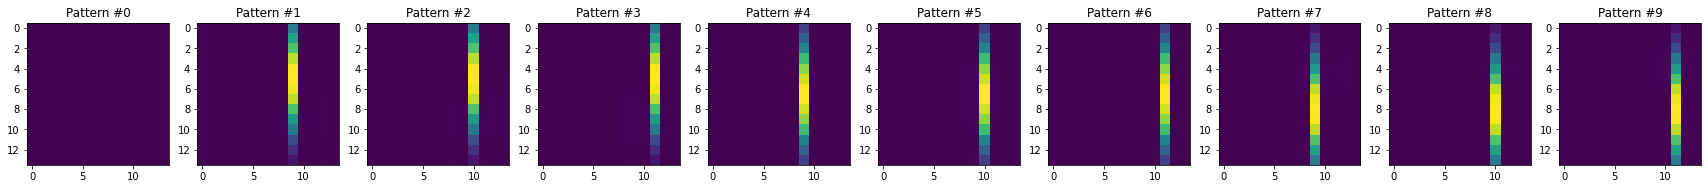

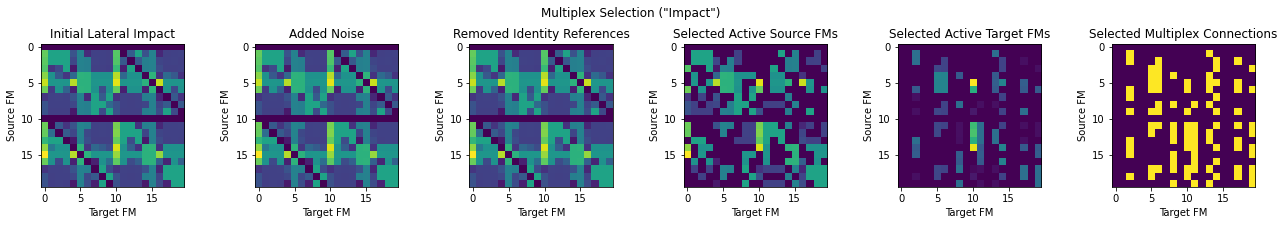

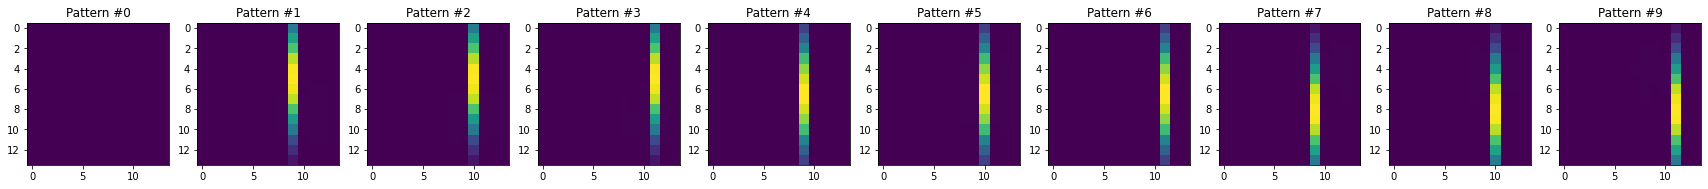

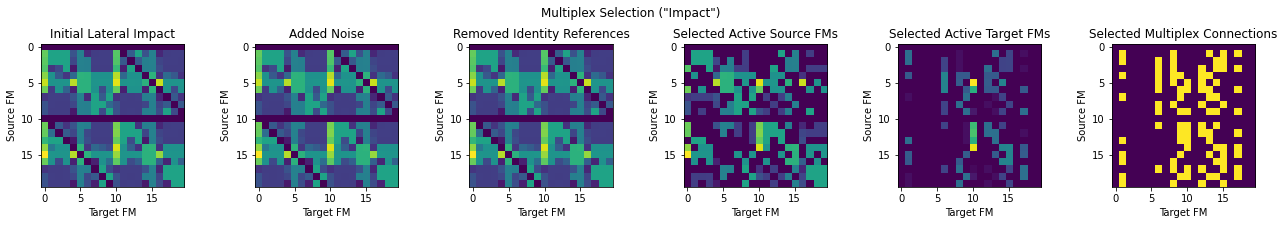

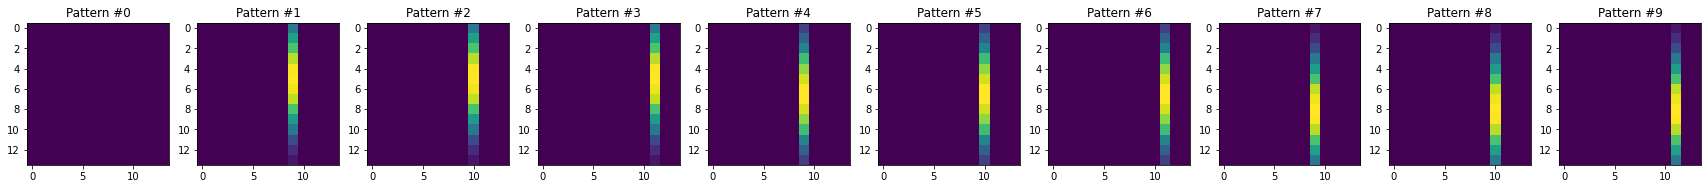

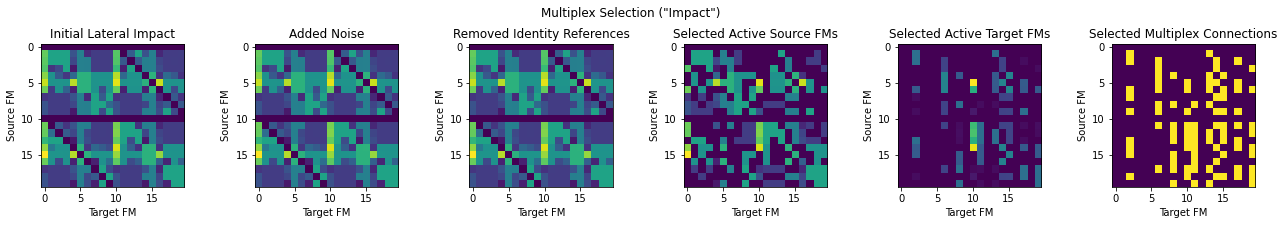

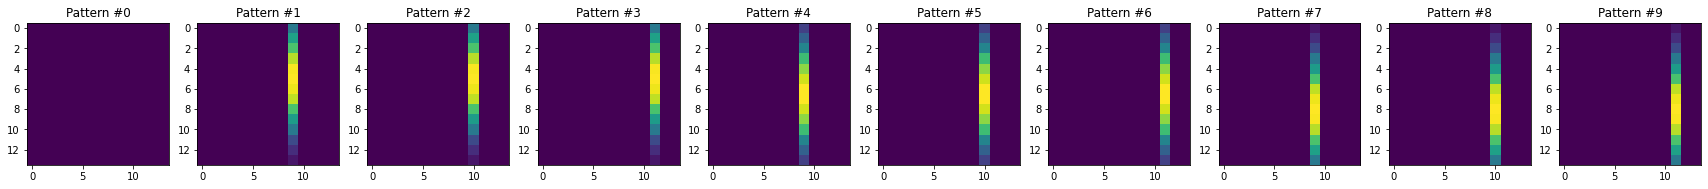

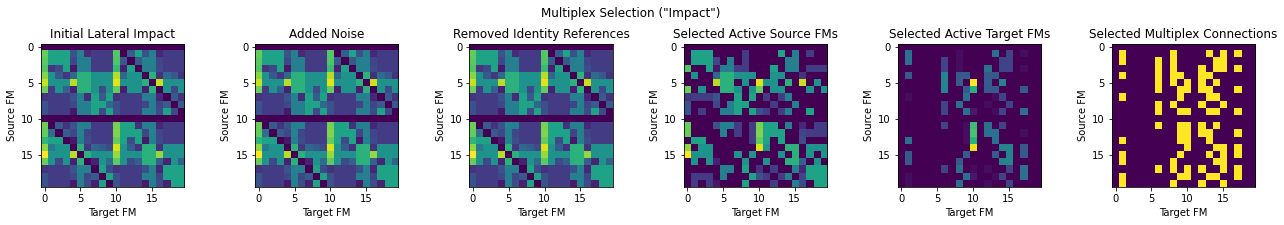

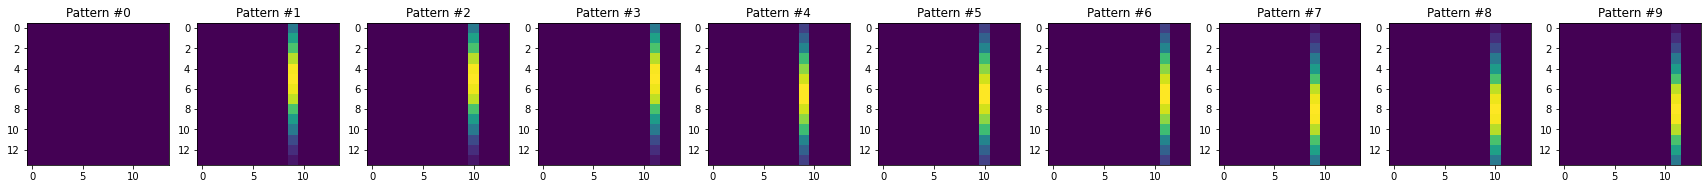

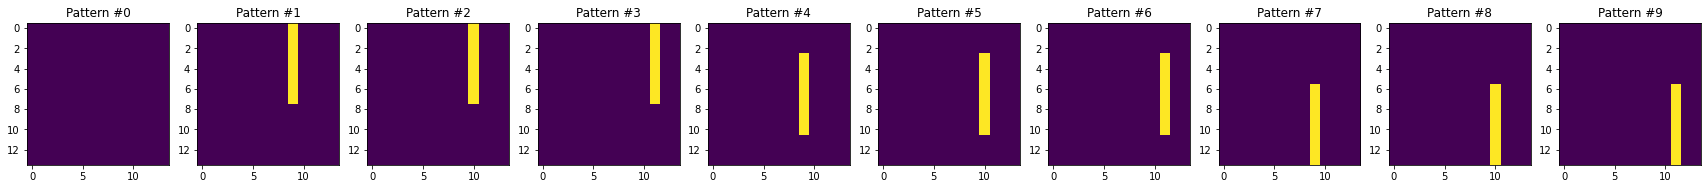

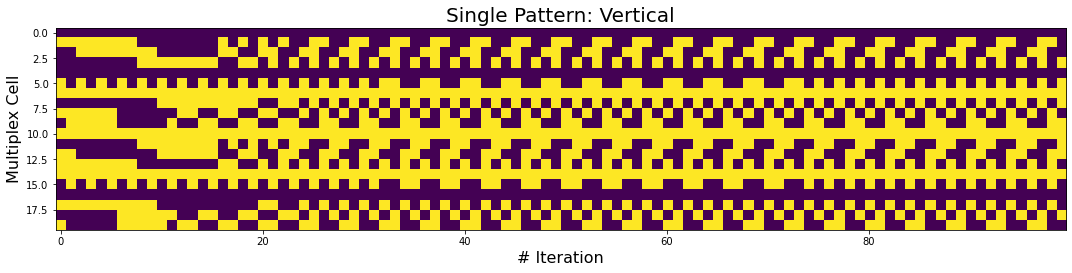

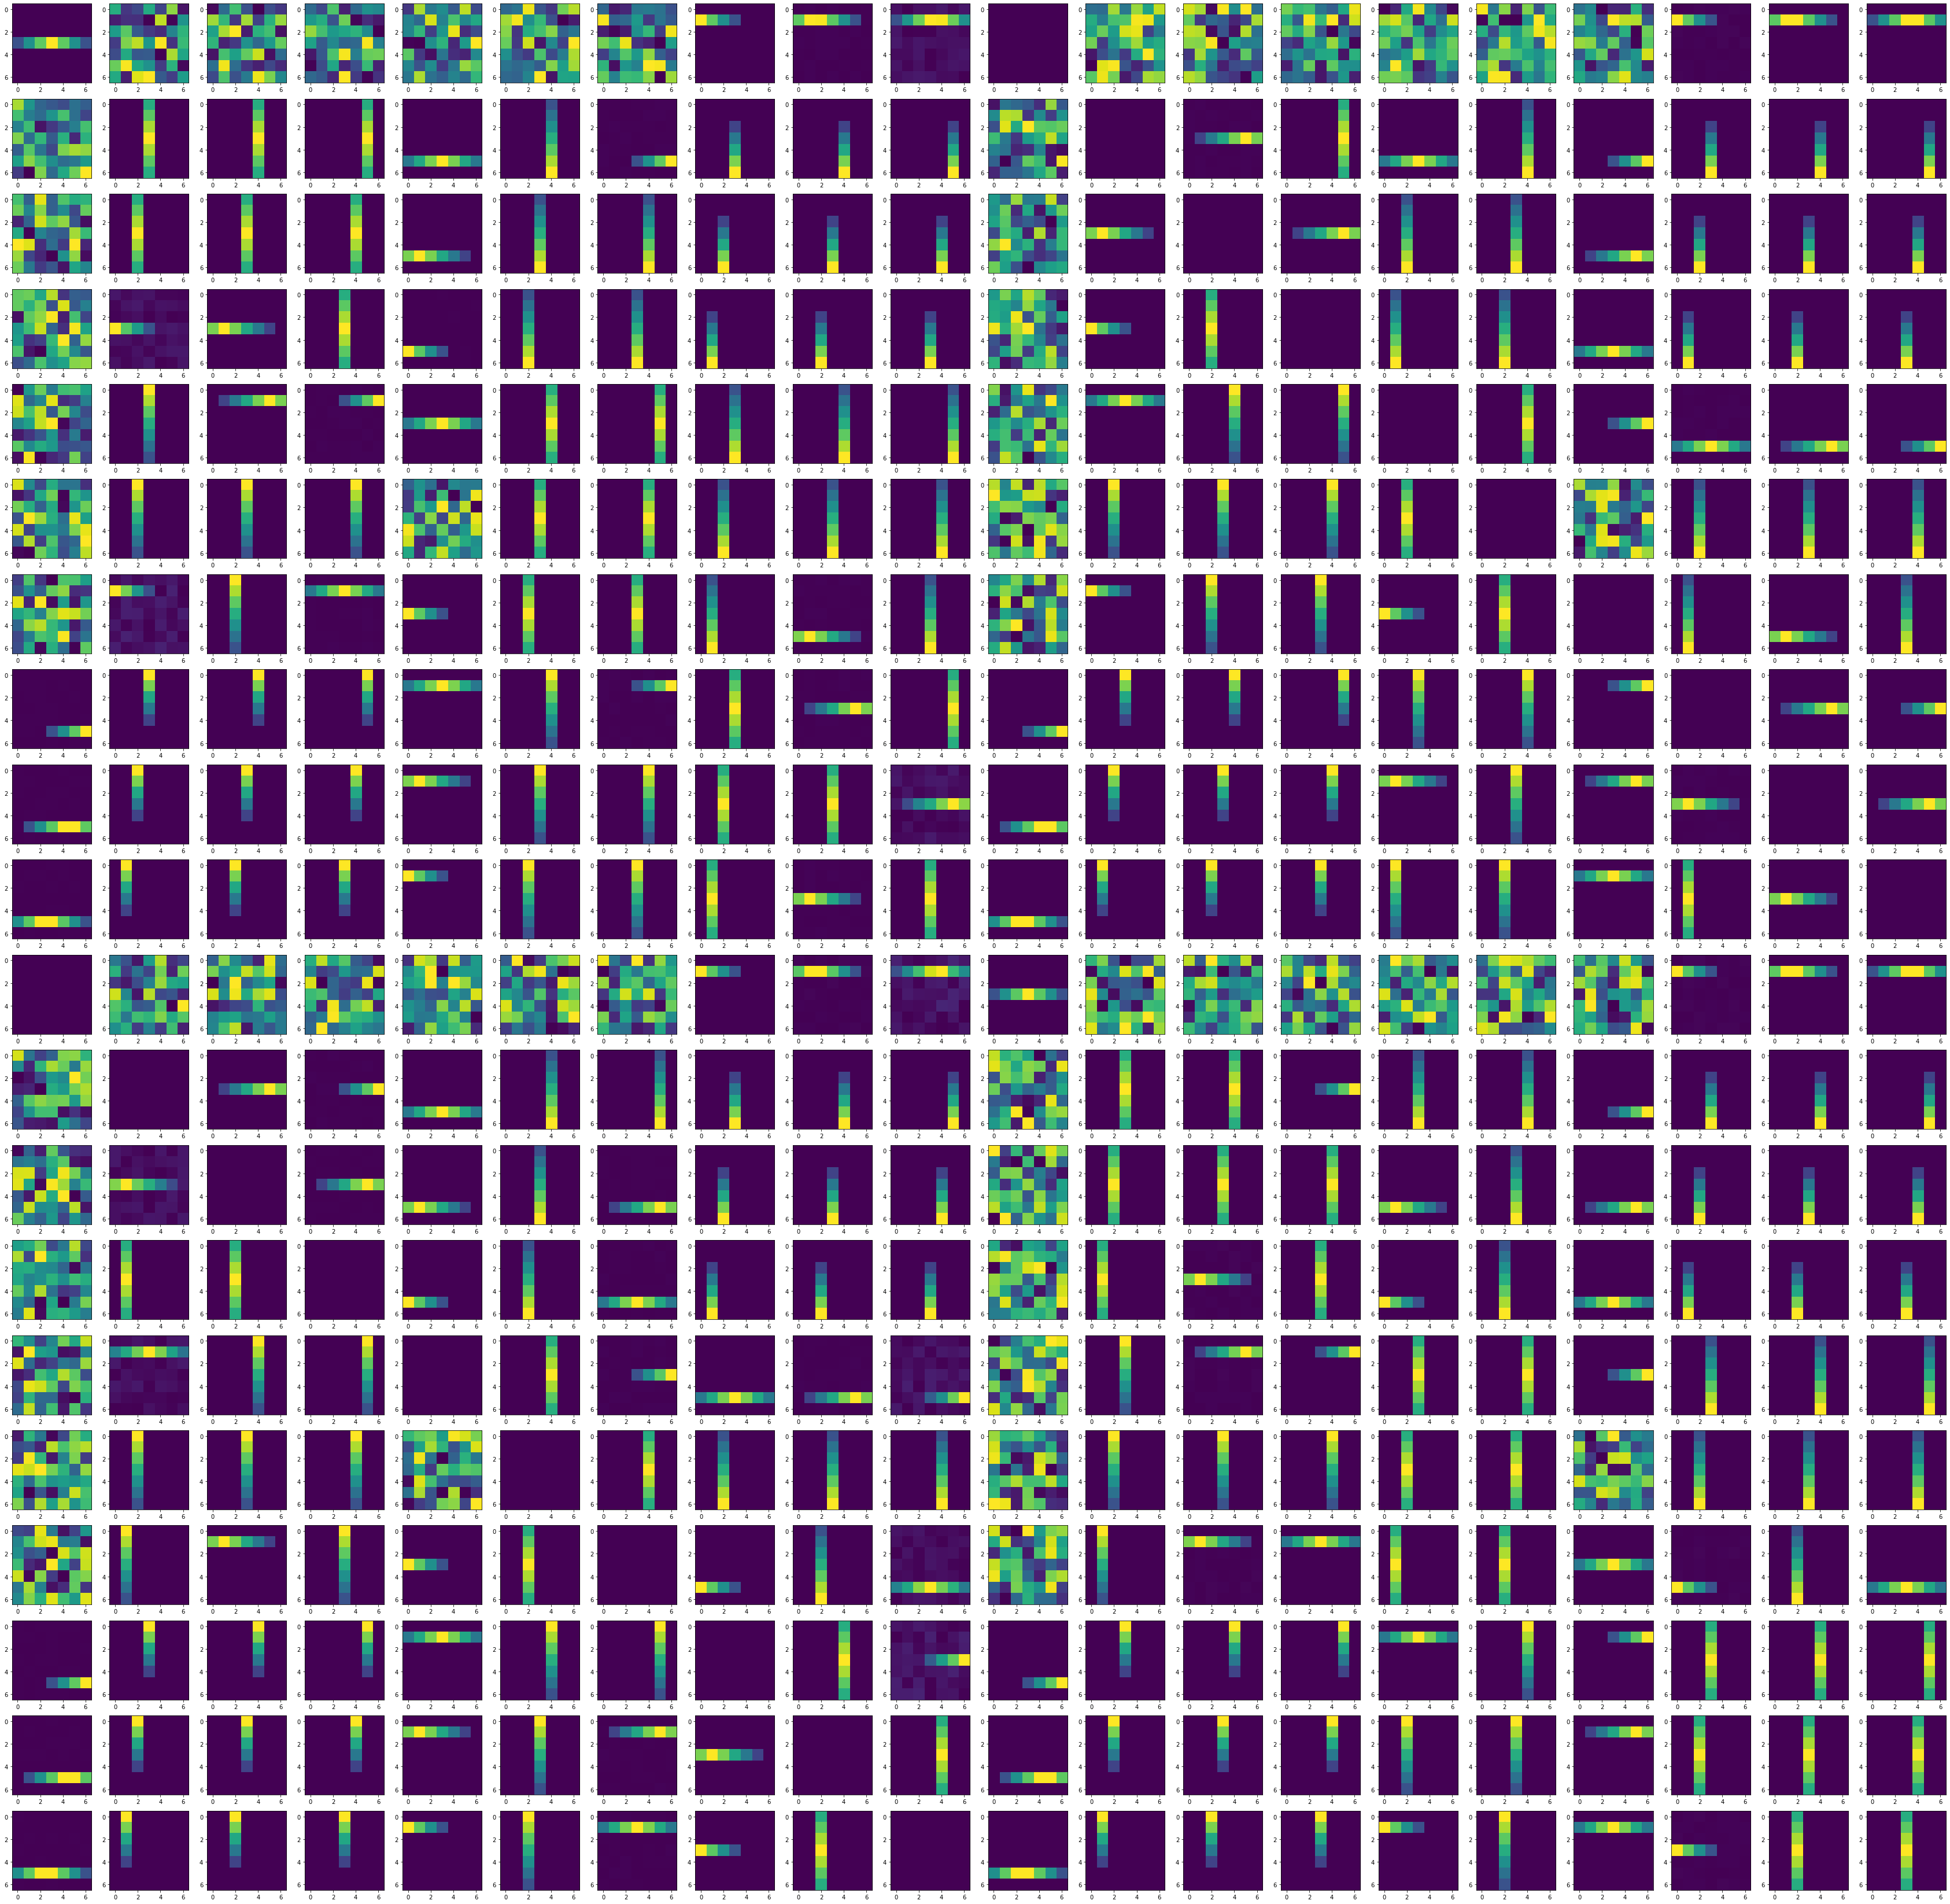

In [9]:
plot_images(images2)
for i in range(100):
    buffer['vertical']['single'].append(do_round(images2, i%10==0))
plot_images(images2)
plot_history(buffer['vertical']['single'], 'Single Pattern: Vertical')
plot_kernels(lcl.K)

### Storing multiple patterns at the same time (horizontal and vertical)

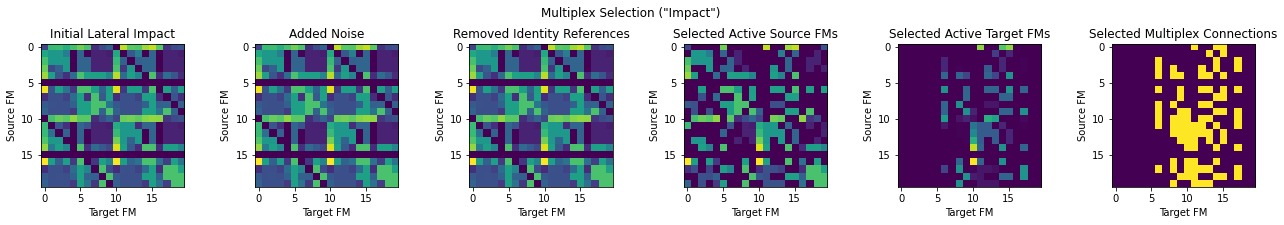

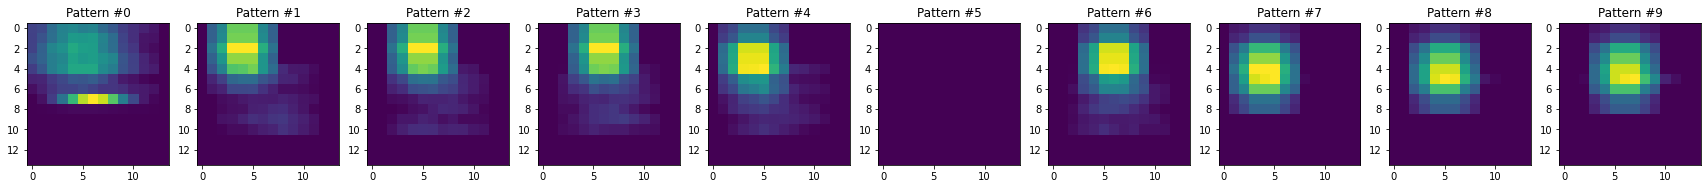

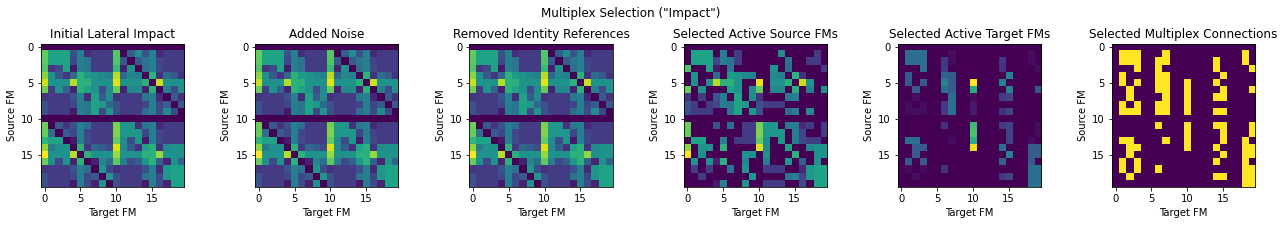

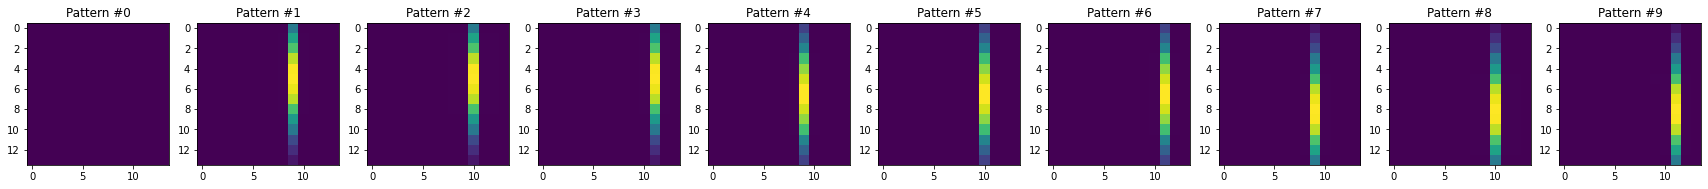

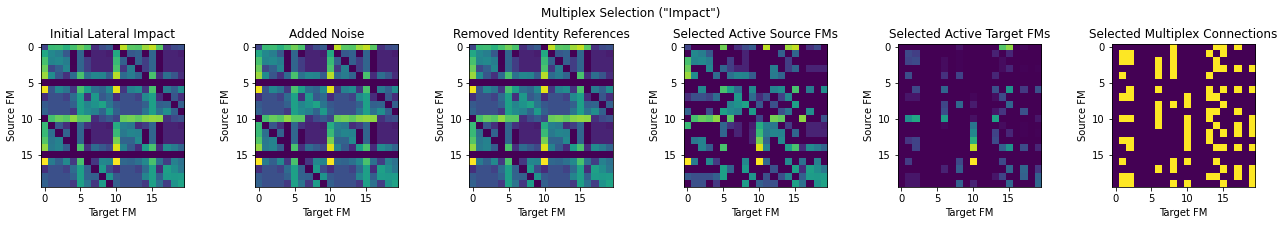

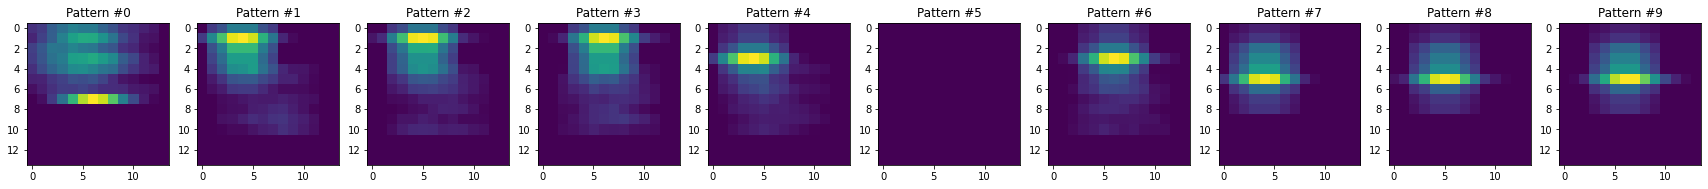

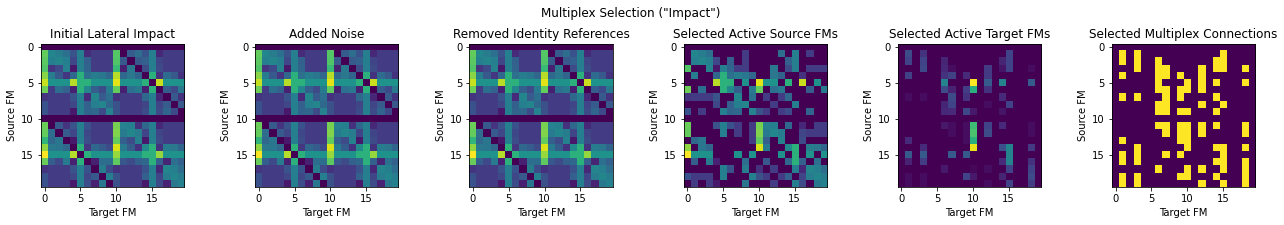

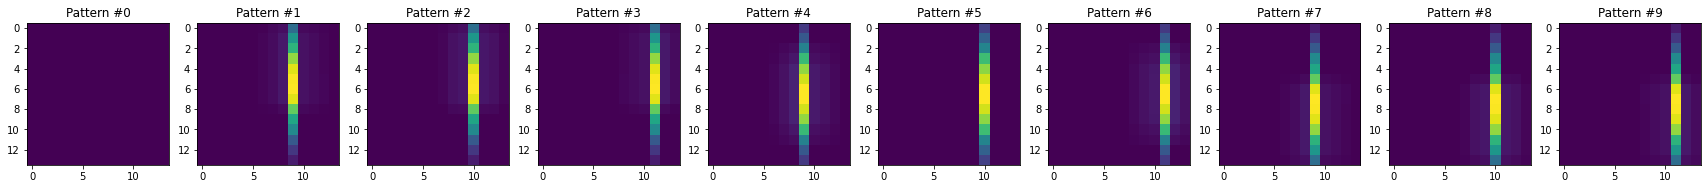

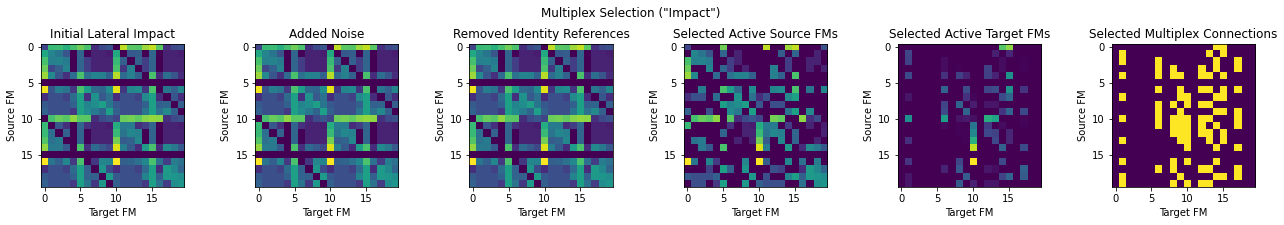

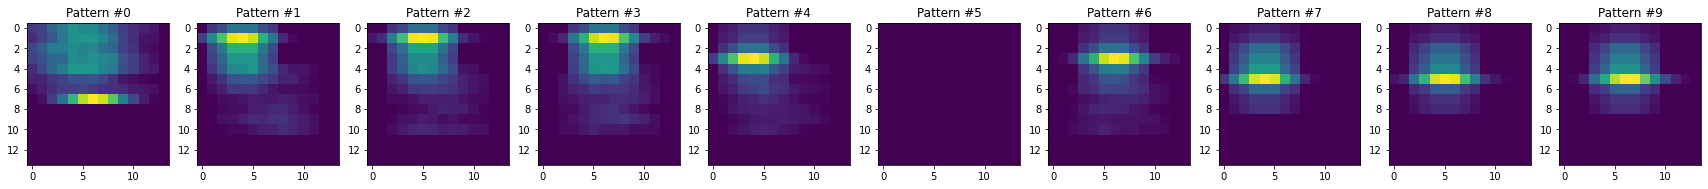

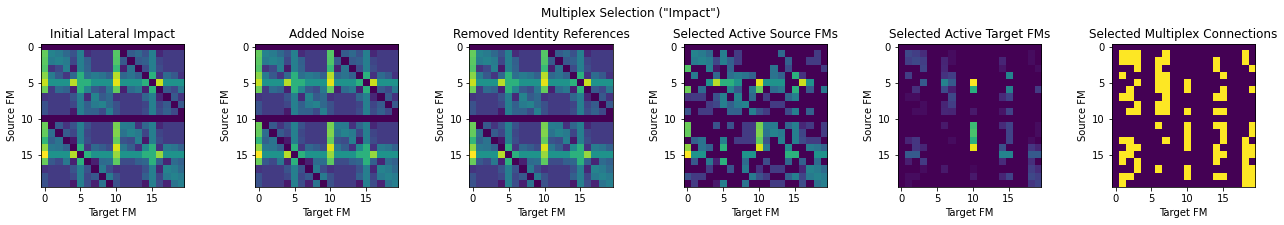

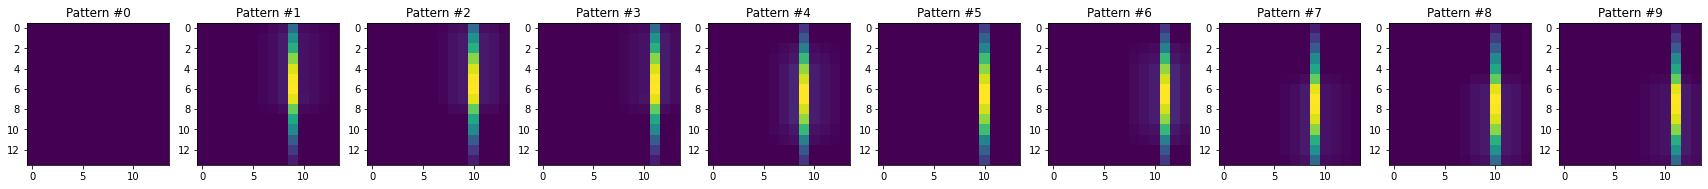

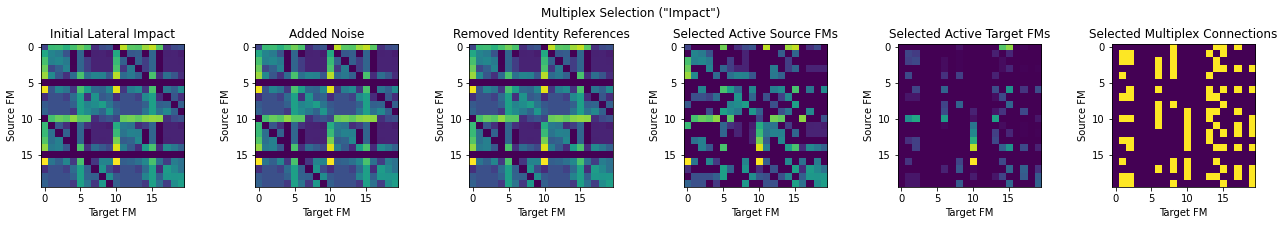

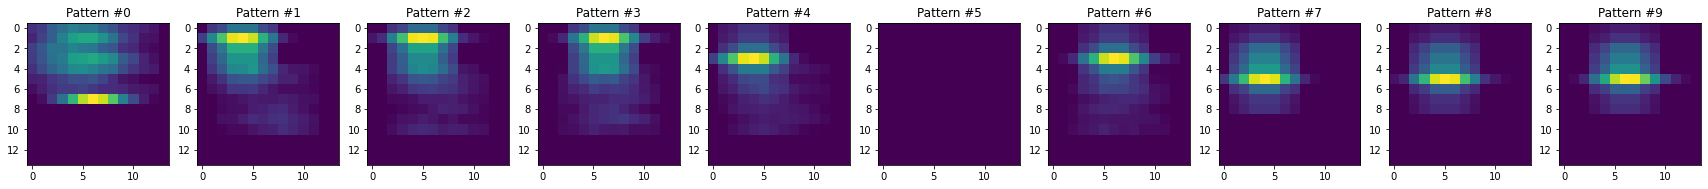

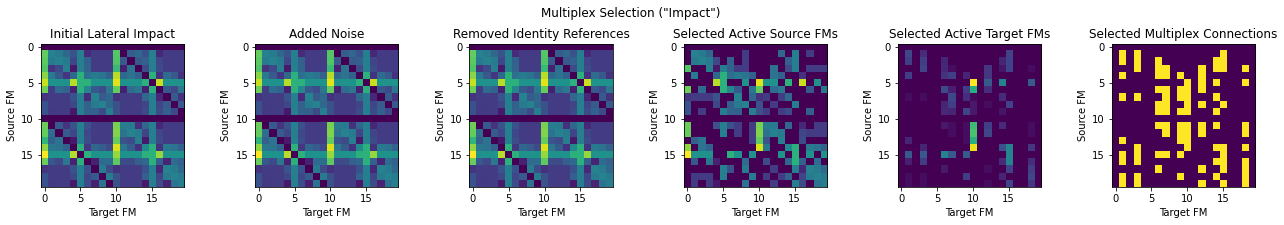

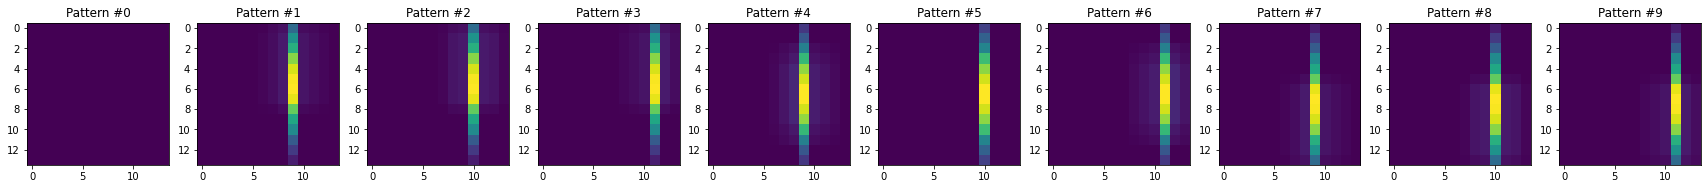

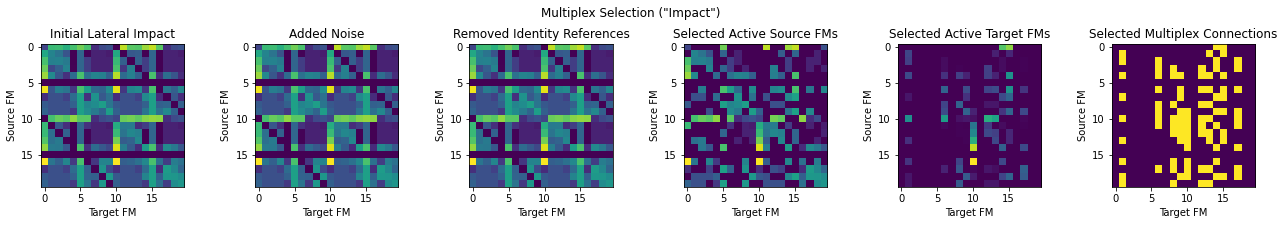

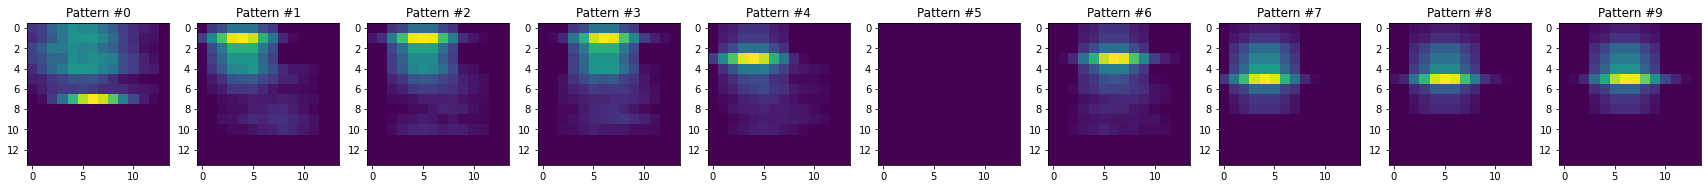

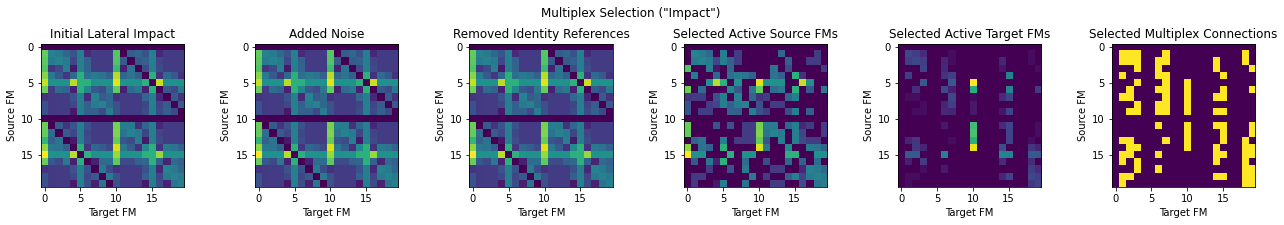

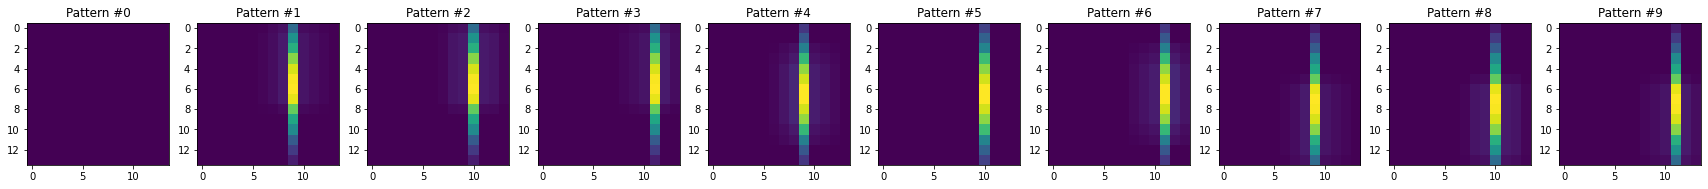

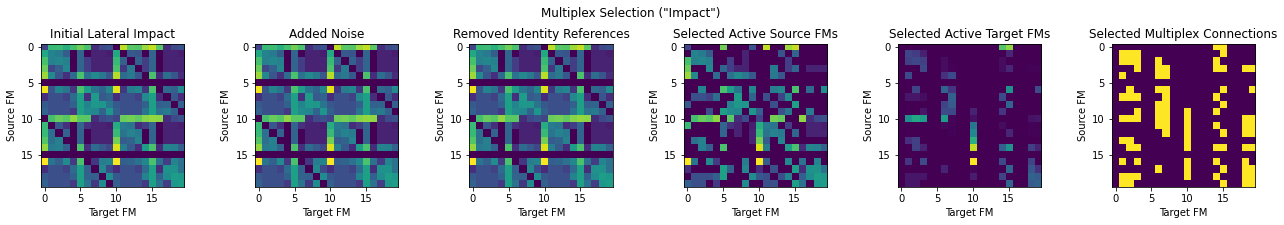

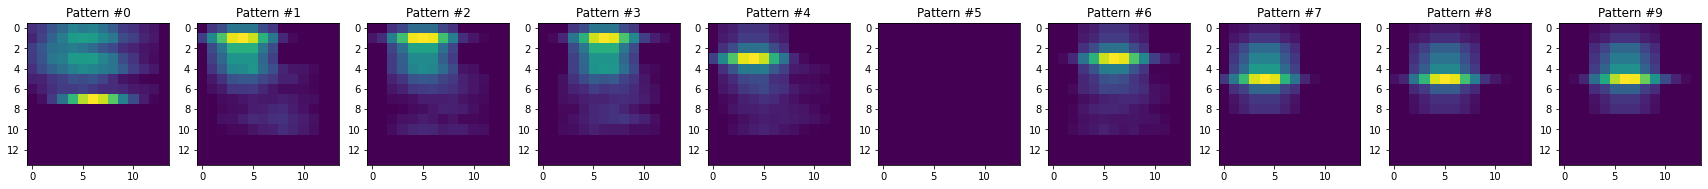

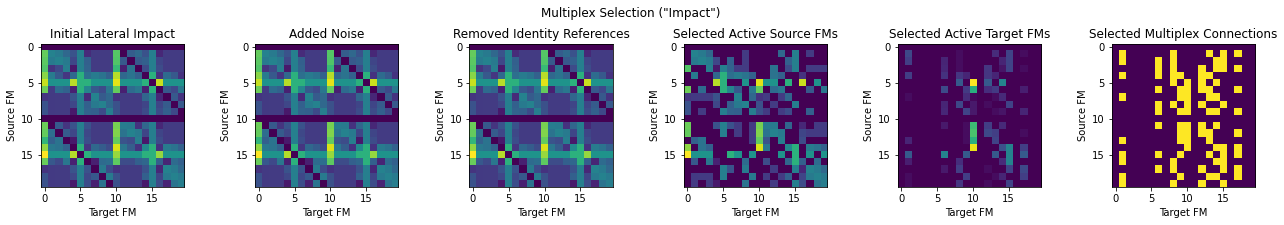

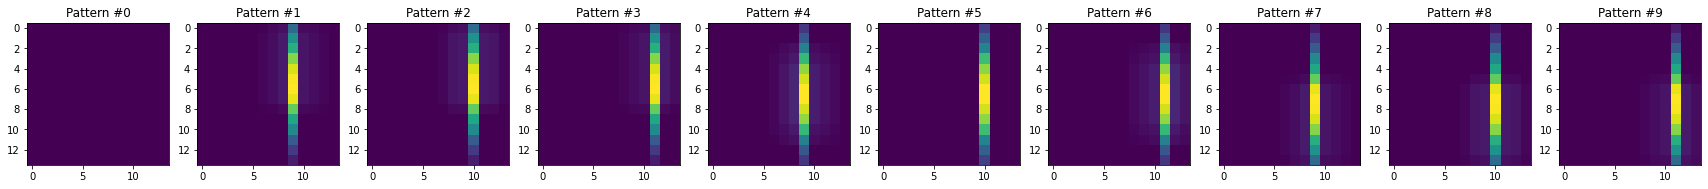

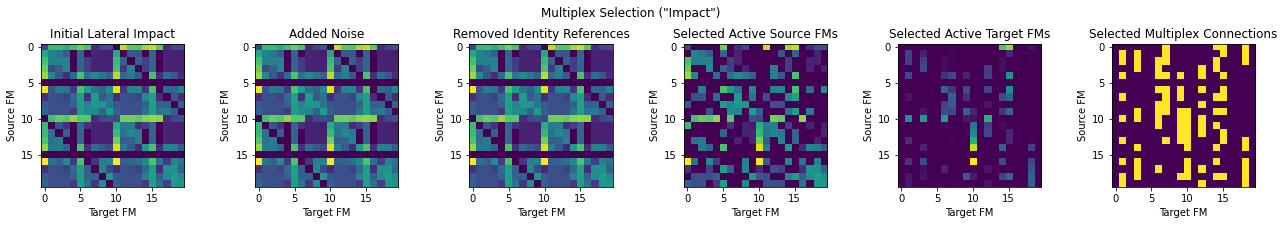

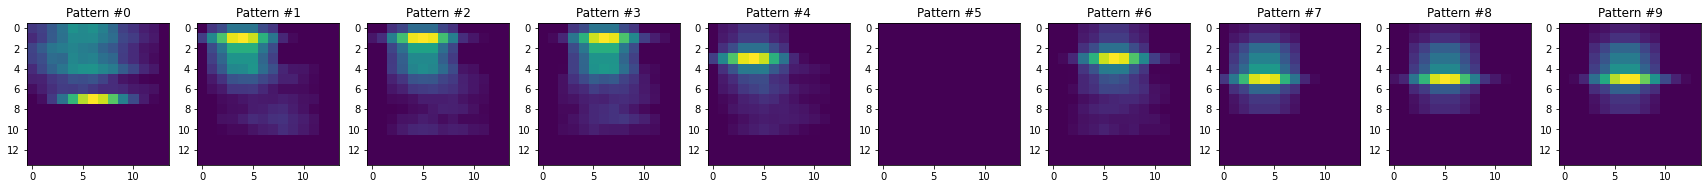

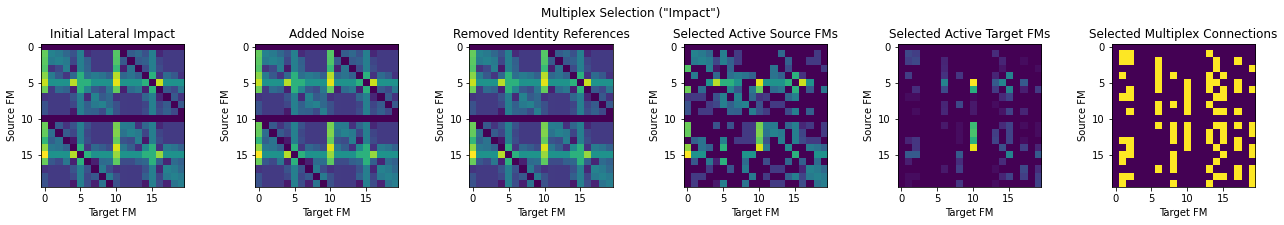

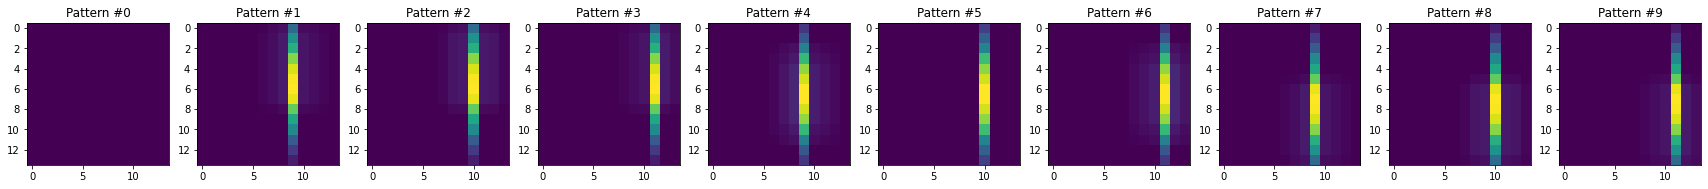

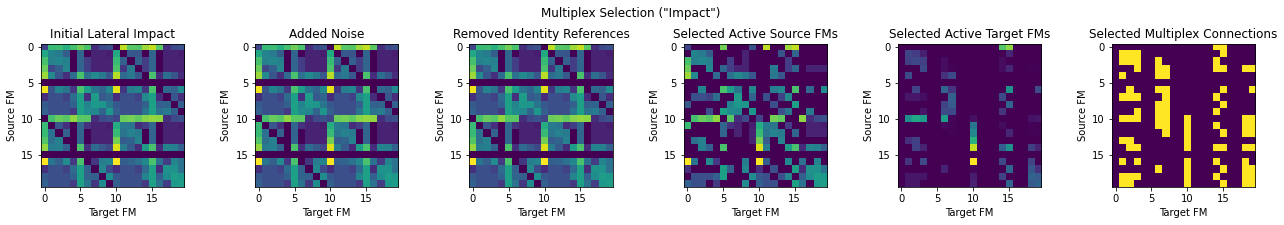

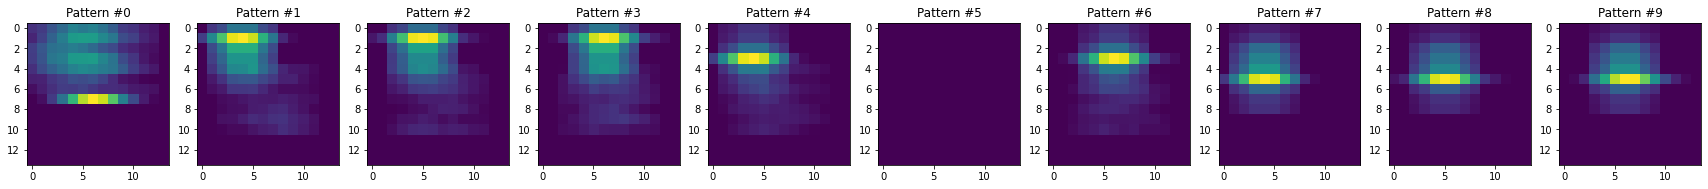

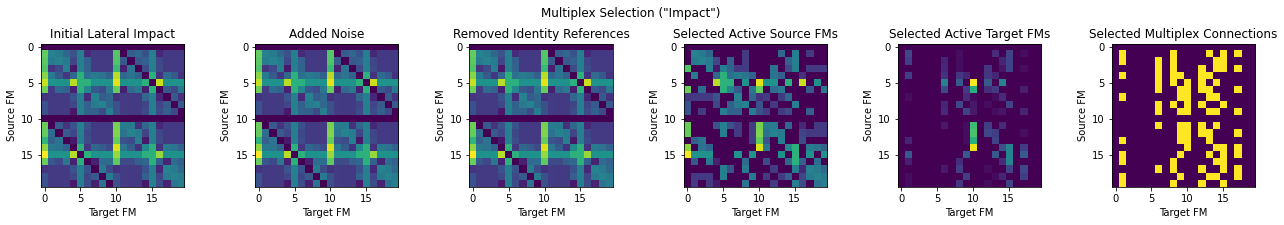

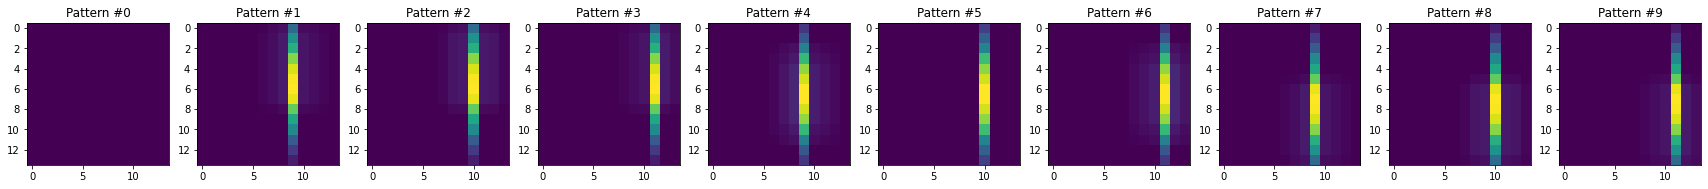

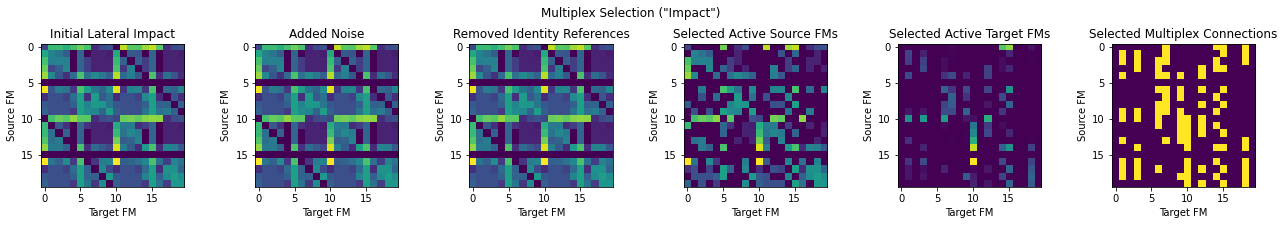

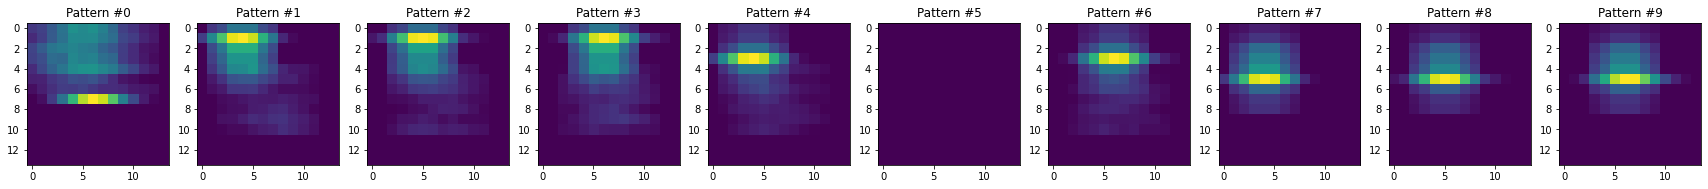

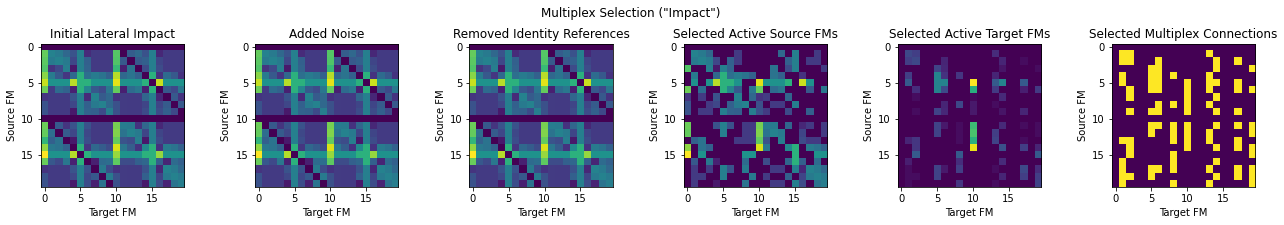

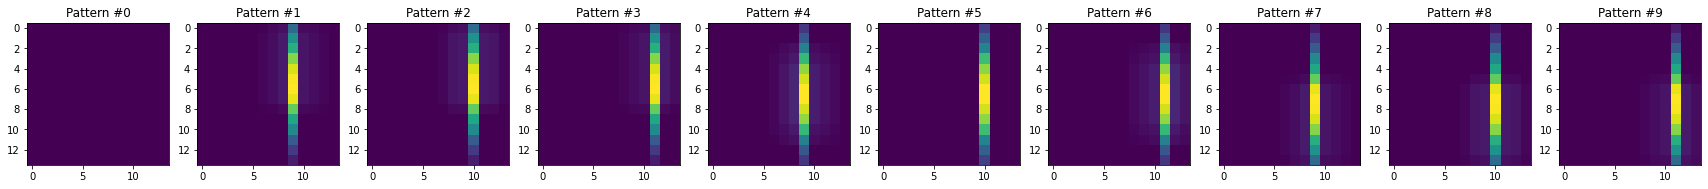

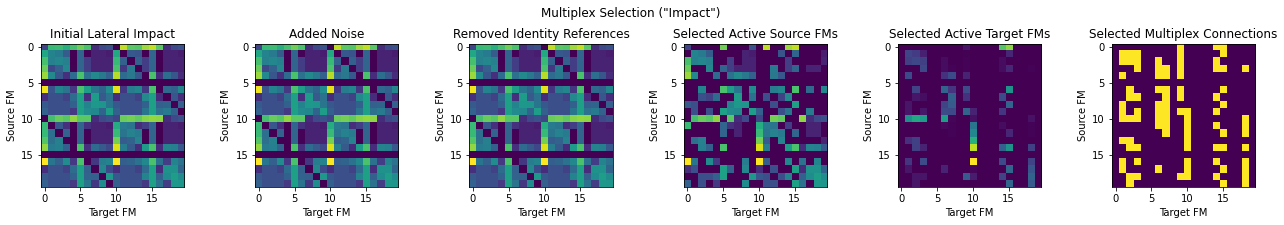

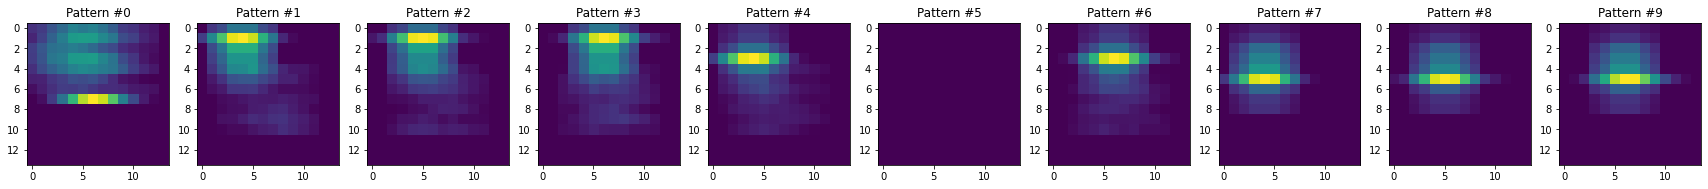

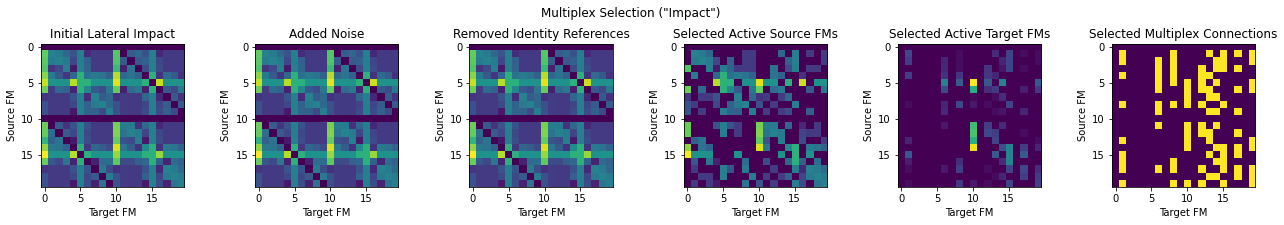

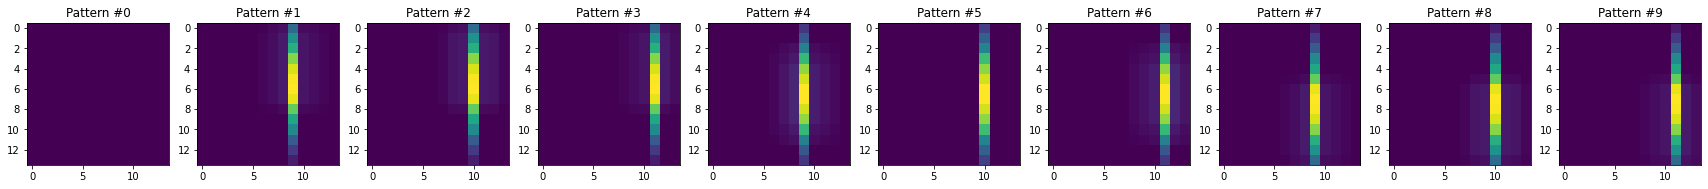

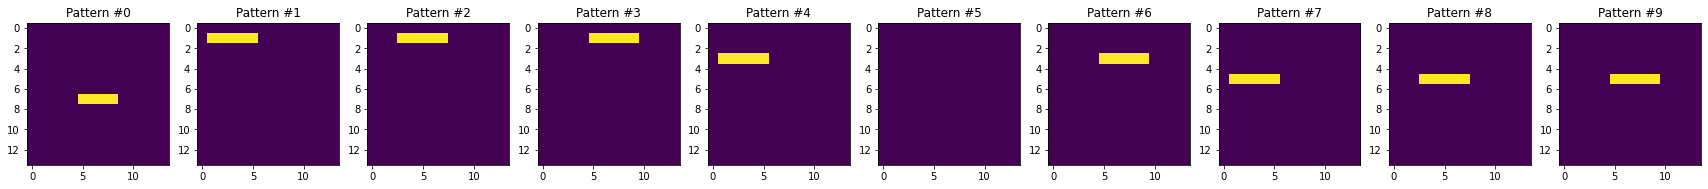

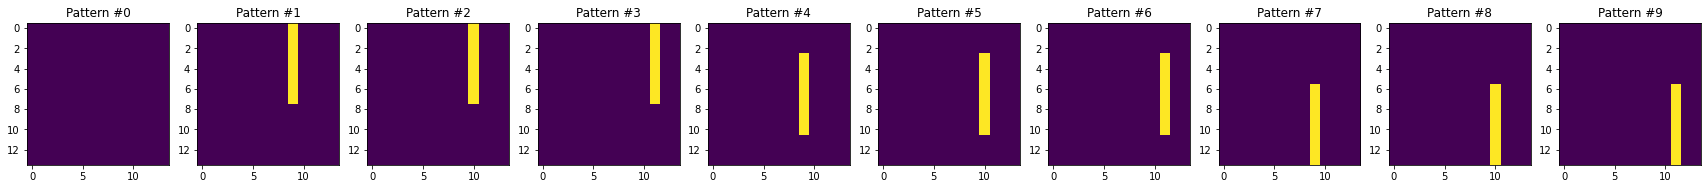

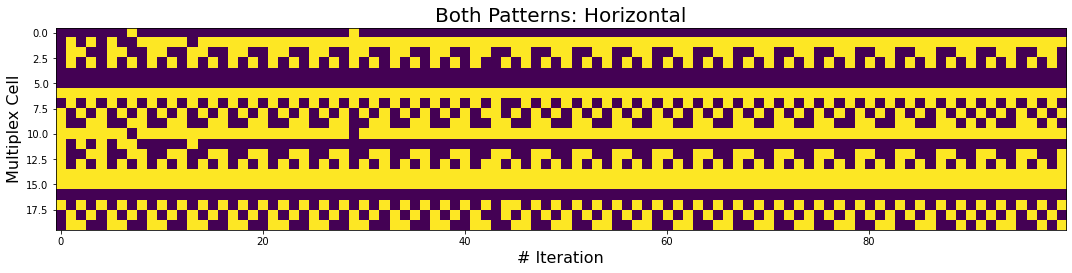

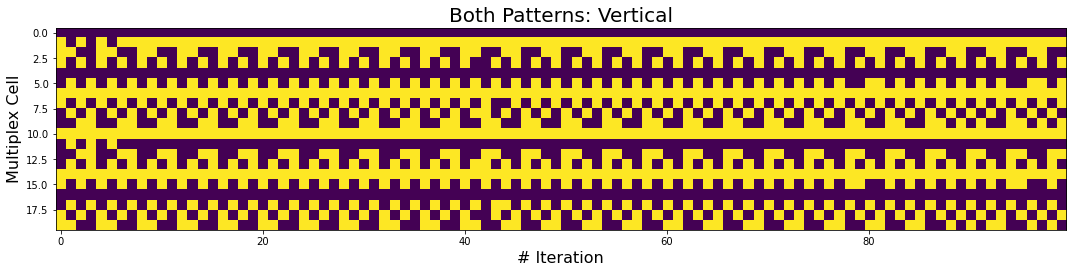

In [10]:
for i in range(100):
    buffer['horizontal']['both'].append(do_round(images, i%10==0))
    buffer['vertical']['both'].append(do_round(images2, i%10==0))
plot_images(images)
plot_images(images2)
plot_history(buffer['horizontal']['both'], 'Both Patterns: Horizontal')
plot_history(buffer['vertical']['both'], 'Both Patterns: Vertical')

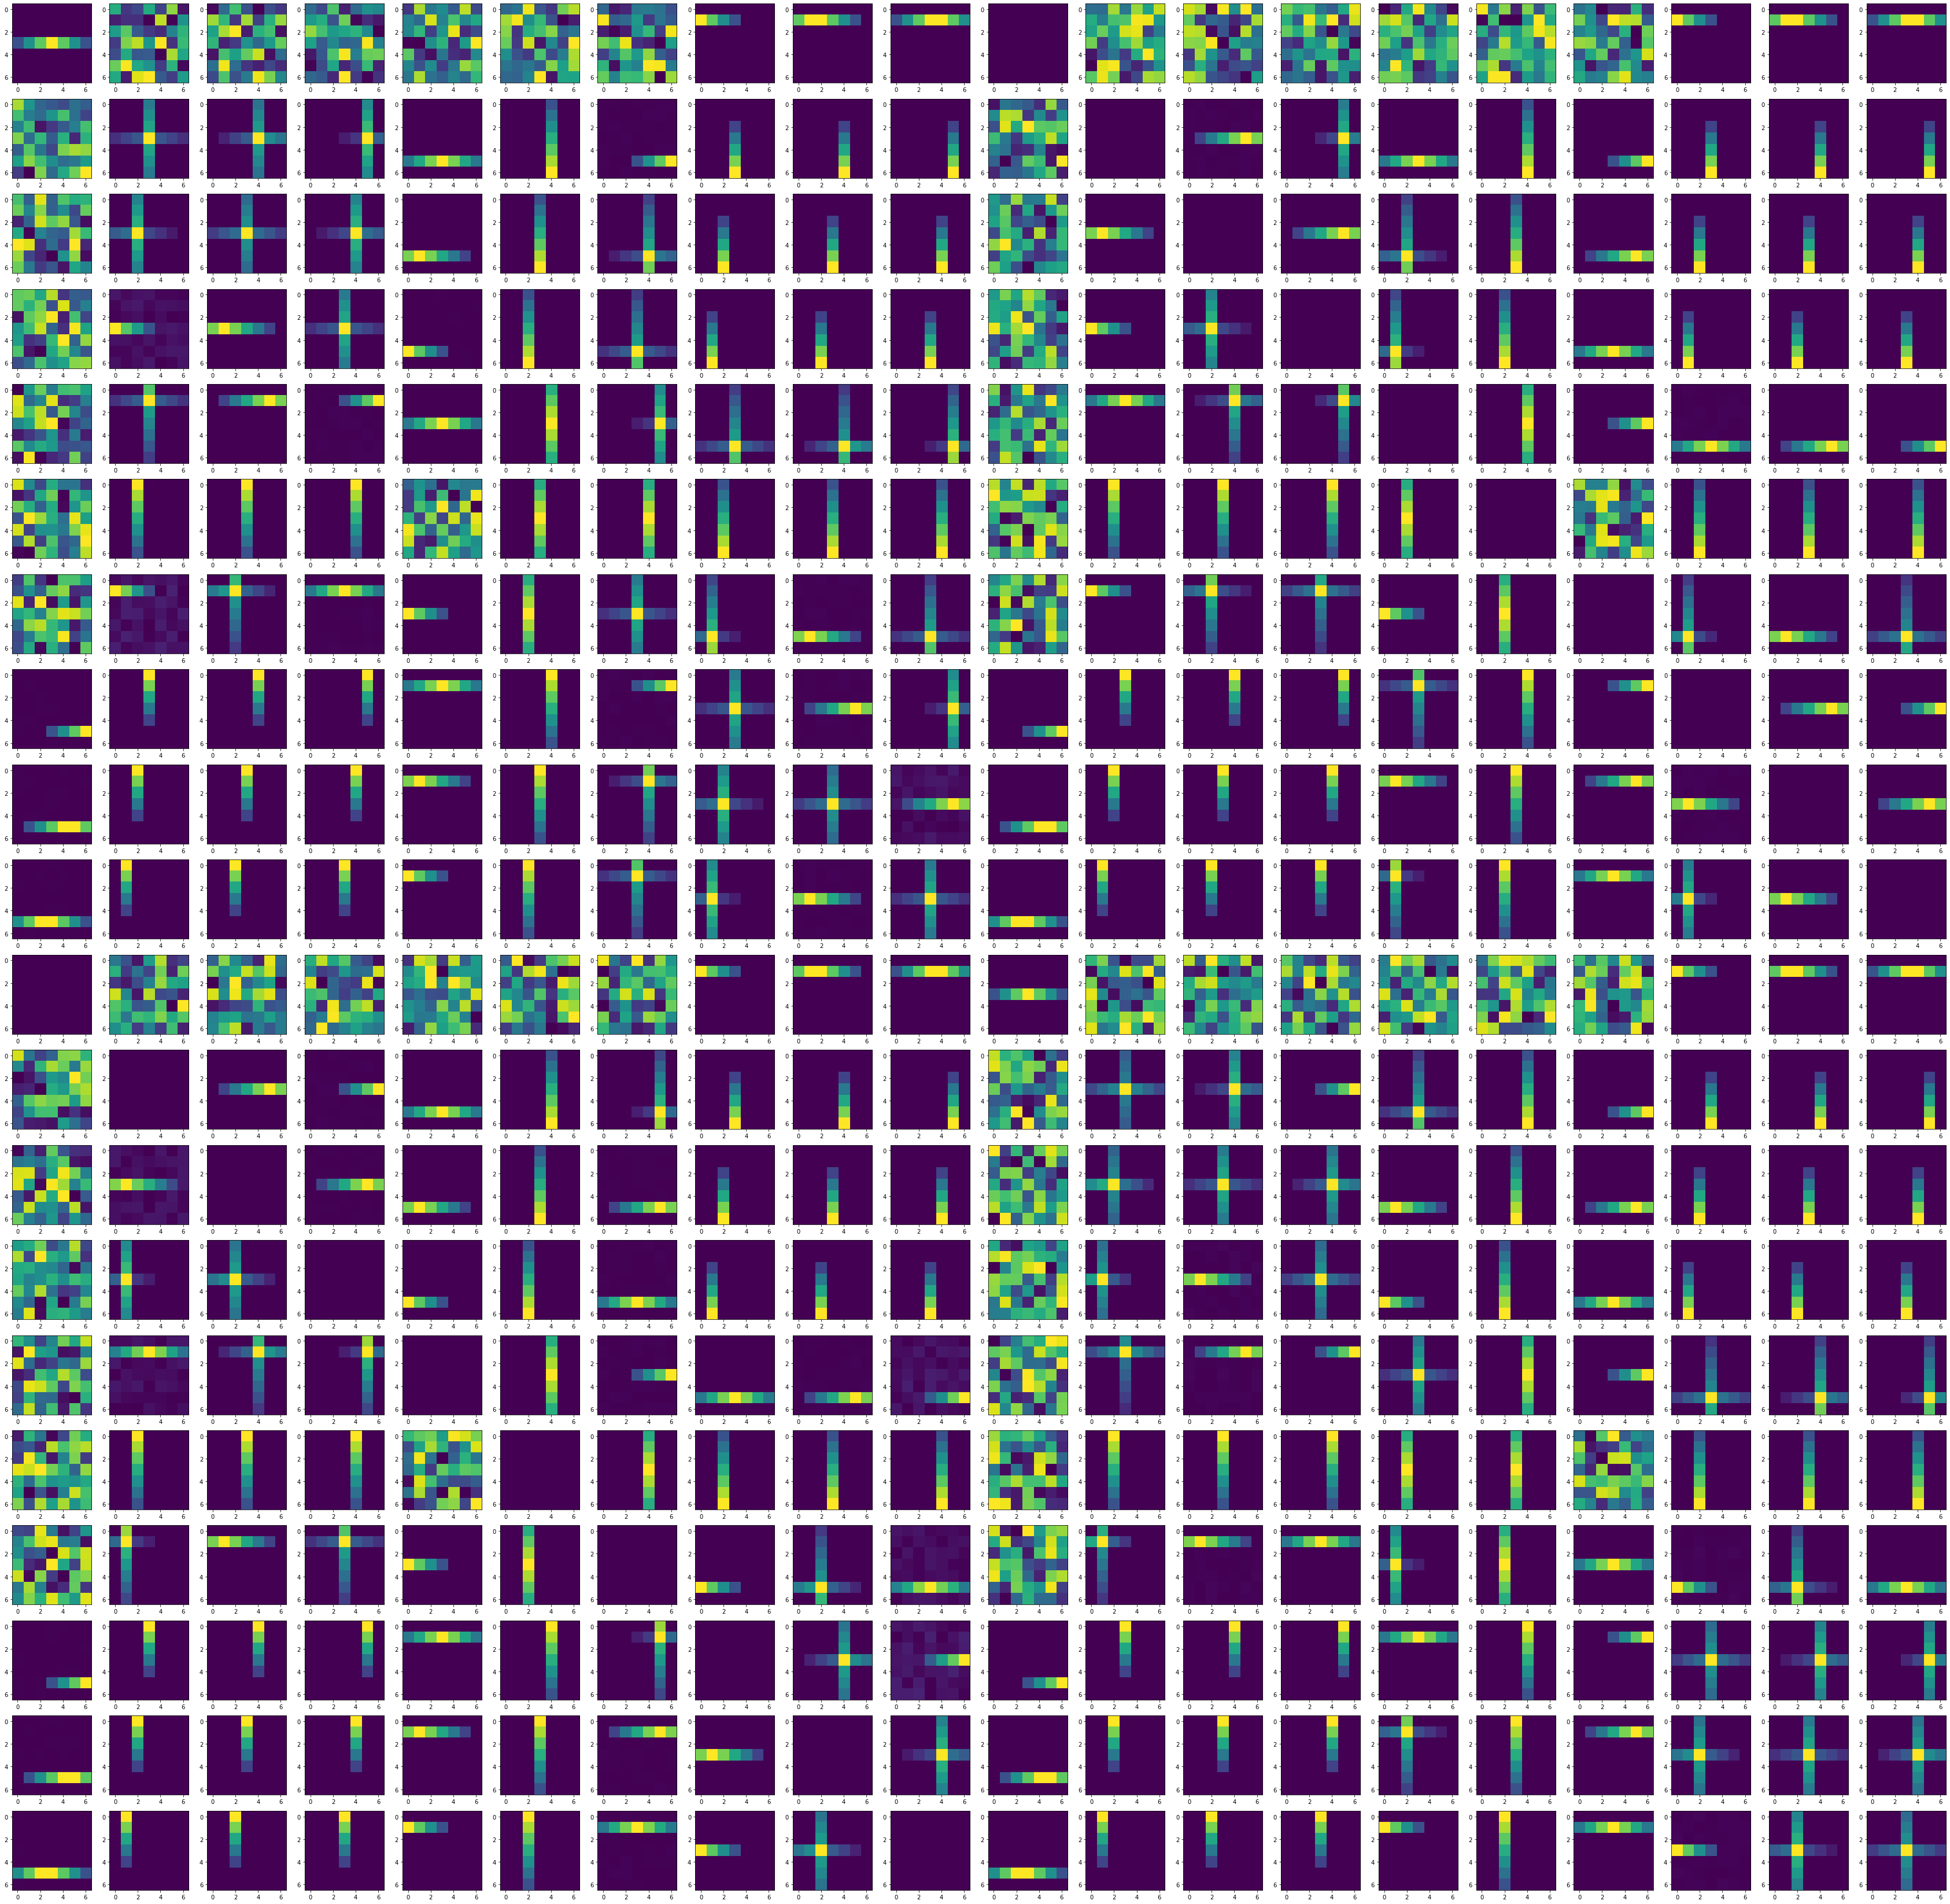

In [11]:
plot_kernels(lcl.K)